# Задача 3. Нейронные сети

* **Дедлайн**: 31.05.2024, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Выбранный dataset: http://ufldl.stanford.edu/housenumbers/.
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
    - FullyConnectedLayer
    - ReluLayer
    - FullyConnectedLayer
- [x] Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [x] * (**+2 балла**) Добавить Batch normalization.
- [x] * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [x] * (**+1 балл**) Также реализовать оптимизатор Adam.

In [4]:
import numpy as np
import random
import torch
import pandas as pd

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [5]:
SEED_VALUE = 0

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Датасет

In [7]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_data = scipy.io.loadmat('dataset/test_32x32.mat')
test_data = scipy.io.loadmat('dataset/test_32x32.mat')

X_train = train_data['X']
y_train = train_data['y']
X_test = test_data['X']
y_test = test_data['y']

X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

y_train = y_train.flatten()
y_test = y_test.flatten()

y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}')
print(f'Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}')
print(f'Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}')

Train data shape: (20825, 32, 32, 3), Train labels shape: (20825,)
Validation data shape: (5207, 32, 32, 3), Validation labels shape: (5207,)
Test data shape: (26032, 32, 32, 3), Test labels shape: (26032,)


In [8]:
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32

transform = A.Compose(
    [
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [9]:
from dataset.dataset import prepare_loader

batch_size = 16

train_data_loader = prepare_loader(X_train, y_train, transform, batch_size=batch_size)
val_data_loader = prepare_loader(X_val, y_val, transform, batch_size=batch_size)
test_data_loader = prepare_loader(X_test, y_test, transform, batch_size=batch_size)

# Слои

In [10]:
import math


class MyFullyConnectedLayer(nn.Module):
    def __init__(self, _input_size, _output_size, bias=True):
        super().__init__()
        self._input_size = _input_size
        self._output_size = _output_size
        
        self.bias = bias
        self.weight = torch.nn.Parameter(torch.Tensor(_output_size, _input_size))
        
        if not bias:
            self.register_parameter('bias', None)
        else:
            self.bias = torch.nn.Parameter(torch.Tensor(_output_size))
        
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        output = x.matmul(self.weight.t())
        
        if self.bias is not None:
            output += self.bias
            
        return output

In [11]:
class MyReluLayer(nn.Module):
    def __init__(self):
        super(MyReluLayer, self).__init__()

    def forward(self, x):
        return torch.max(torch.zeros_like(x), x)

In [12]:
from collections import OrderedDict


class MyClassificationNN(nn.Module):
    def __init__(self, _input_size, hidden_size, _output_size, bn=False):
        super(MyClassificationNN, self).__init__()
        classification_model_without_bn = nn.Sequential(OrderedDict([
            ('fc1', MyFullyConnectedLayer(_input_size, hidden_size)),
            ('relu', MyReluLayer()),
            ('fc2', MyFullyConnectedLayer(hidden_size, _output_size))
        ]))
        
        classification_model_with_bn = nn.Sequential(OrderedDict([
            ('fc1', MyFullyConnectedLayer(_input_size, hidden_size)),
            ('bn1', nn.BatchNorm1d(hidden_size)),
            ('relu', MyReluLayer()),
            ('fc2', MyFullyConnectedLayer(hidden_size, _output_size)),
            ('bn2', nn.BatchNorm1d(_output_size)),
        ]))
        
        self.classification = classification_model_with_bn if bn else classification_model_without_bn

    def forward(self, x):
        return self.classification(x)

# Вспомогательные функции

In [22]:
def transform_image(x):
    return x.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)

In [23]:
def check_gradients(model, data, target_data, loss_fn, epsilon=1e-5, num_params_to_check=10):
    data = transform_image(data)
    target_data = target_data.to(device)
    model.zero_grad()
    loss = loss_fn(model(data), target_data)
    loss.backward()

    params_to_check = list(model.named_parameters())
    num_params = sum(p[1].numel() for p in params_to_check if p[1].requires_grad)
    if num_params_to_check > num_params:
        num_params_to_check = num_params

    indices = torch.randperm(num_params)[:num_params_to_check]

    for param_name, param in params_to_check: 
        if param.requires_grad:
            print(f"Checking gradient for parameter: {param_name}")
            
            grad = param.grad
            param_flat = param.data.view(-1)
            grad_flat = grad.view(-1)

            for idx in indices:
                if idx >= param_flat.size(0):
                    break

                param_flat[idx] += epsilon
                loss_plus = loss_fn(model(data), target_data)
                param_flat[idx] -= 2 * epsilon
                loss_minus = loss_fn(model(data), target_data)
                param_flat[idx] += epsilon

                numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
                diff = torch.abs(numerical_grad - grad_flat[idx]).item()

                if diff > epsilon:
                    print(f'Gradient check failed for parameter {param_name}')
                    return False

    print('Gradients check passed!')
    return True

In [24]:
def train_model(model, optimizer, train_loader, val_loader, num_epochs, learning_rate, weight_decay, df):
    criterion = nn.CrossEntropyLoss().to(device)

    optimizer = optimizer(model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)

    train_losses = []
    val_losses = []
    best_acc = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images = transform_image(images)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(tqdm(val_loader)):
                images = transform_image(images)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_val / total_val

        print(f'Epoch [{epoch + 1} out of {num_epochs}], '
              f'Train --> loss: {train_losses[-1]:.4f} & accuracy: {train_accuracy * 100:.2f}%, '
              f'Validation --> loss: {val_losses[-1]:.4f} & accuracy: {val_accuracy * 100:.2f}%')

        best_acc = max(best_acc, val_accuracy)

        check_gradients(model, *next(iter(train_data_loader)), loss_fn=criterion)

    return train_losses, val_losses, pd.concat(
        [df, pd.DataFrame({"optimizer": [str(optimizer).split('(')[0].replace(' ', '')],
                           "accuracy": [best_acc],
                           "learning_rate": [learning_rate],
                           "weight_decay": [weight_decay],
                           })])

In [25]:
def train_grid_search(params, num_epochs, bn, results):
    for param in params:
        model = MyClassificationNN(_input_size=IMAGE_HEIGHT*IMAGE_WIDTH*3,
                                   hidden_size=256,
                                   _output_size=10,
                                   bn=bn).to(device)

        print(f"Params: lr={param[1]}, w={param[2]}, opt={param[0]}")
        train_losses, val_losses, results = train_model(model, param[0], train_data_loader, val_data_loader, num_epochs, param[1], weight_decay=param[2], df=results)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(tqdm(test_data_loader)):
                images = transform_image(images)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {100 * accuracy:.2f}%")

        plt.plot(range(num_epochs), train_losses, label='Train Loss')
        plt.plot(range(num_epochs), val_losses, label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Train/Val Losses')
        plt.legend()
        plt.show()

        print(f"{train_losses=}\n{val_losses}")

    return results

# Обучение

In [13]:
from my_adam import Adam

res = pd.DataFrame(columns=['optimizer', 'accuracy', 'learning_rate', 'weight_decay'])
num_epochs = 10

weight_decay_list = [0.0001, 0.001, 0.01] 
learning_rates = [0.0001, 0.001, 0.01]
optimizers = [Adam, optim.RMSprop] 
params = [(x, y, z) for x in optimizers for y in learning_rates for z in weight_decay_list]

Params lr=0.0001, w=0.0001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 461.15it/s]

Epoch [1 out of 10], Train --> loss: 2.2326 & accuracy: 19.26%, Validation --> loss: 2.2132 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 398.15it/s]

Epoch [2 out of 10], Train --> loss: 2.1849 & accuracy: 20.07%, Validation --> loss: 2.1514 & accuracy: 20.66%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 505.72it/s]

Epoch [3 out of 10], Train --> loss: 2.1004 & accuracy: 23.52%, Validation --> loss: 2.0441 & accuracy: 25.75%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 530.81it/s]

Epoch [4 out of 10], Train --> loss: 1.9812 & accuracy: 29.20%, Validation --> loss: 1.9156 & accuracy: 31.55%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 560.80it/s]

Epoch [5 out of 10], Train --> loss: 1.8621 & accuracy: 35.13%, Validation --> loss: 1.8137 & accuracy: 40.64%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 562.75it/s]

Epoch [6 out of 10], Train --> loss: 1.7568 & accuracy: 41.50%, Validation --> loss: 1.7031 & accuracy: 44.94%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 553.76it/s]

Epoch [7 out of 10], Train --> loss: 1.6658 & accuracy: 45.90%, Validation --> loss: 1.6264 & accuracy: 46.69%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 530.97it/s]

Epoch [8 out of 10], Train --> loss: 1.5887 & accuracy: 49.21%, Validation --> loss: 1.5555 & accuracy: 50.59%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 540.94it/s]

Epoch [9 out of 10], Train --> loss: 1.5252 & accuracy: 52.00%, Validation --> loss: 1.5013 & accuracy: 52.78%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 538.46it/s]

Epoch [10 out of 10], Train --> loss: 1.4727 & accuracy: 54.27%, Validation --> loss: 1.4522 & accuracy: 54.12%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 771.12it/s]


Test Accuracy: 54.64%


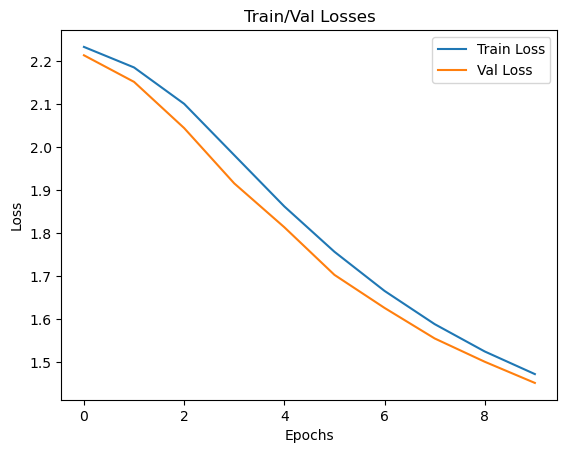

train_losses=[2.232601665498291, 2.1849062136058253, 2.100422997170696, 1.981197812498623, 1.8620576876832227, 1.7567827275821142, 1.665843080448848, 1.5887287774576753, 1.5251668699417613, 1.4726701229581818]
[2.213173789846385, 2.151399832196031, 2.0440913548498796, 1.9156198406512022, 1.8137244662624195, 1.7031156577946949, 1.6263546914410738, 1.5554641002526313, 1.5012974066237, 1.4521510198803766]
Params lr=0.0001, w=0.001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 528.67it/s]

Epoch [1 out of 10], Train --> loss: 2.2337 & accuracy: 19.18%, Validation --> loss: 2.2125 & accuracy: 20.74%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 528.79it/s]

Epoch [2 out of 10], Train --> loss: 2.1806 & accuracy: 22.55%, Validation --> loss: 2.1488 & accuracy: 26.25%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 538.24it/s]

Epoch [3 out of 10], Train --> loss: 2.0837 & accuracy: 27.70%, Validation --> loss: 2.0195 & accuracy: 32.01%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 548.18it/s]

Epoch [4 out of 10], Train --> loss: 1.9422 & accuracy: 33.65%, Validation --> loss: 1.8813 & accuracy: 38.62%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 528.77it/s]

Epoch [5 out of 10], Train --> loss: 1.8047 & accuracy: 39.84%, Validation --> loss: 1.7453 & accuracy: 43.88%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 542.63it/s]

Epoch [6 out of 10], Train --> loss: 1.6925 & accuracy: 44.85%, Validation --> loss: 1.6471 & accuracy: 46.50%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 561.90it/s]

Epoch [7 out of 10], Train --> loss: 1.6038 & accuracy: 48.92%, Validation --> loss: 1.5638 & accuracy: 50.59%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 538.98it/s]

Epoch [8 out of 10], Train --> loss: 1.5311 & accuracy: 52.10%, Validation --> loss: 1.5094 & accuracy: 51.62%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 531.64it/s]

Epoch [9 out of 10], Train --> loss: 1.4714 & accuracy: 55.07%, Validation --> loss: 1.4499 & accuracy: 55.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 536.47it/s]

Epoch [10 out of 10], Train --> loss: 1.4198 & accuracy: 56.95%, Validation --> loss: 1.3953 & accuracy: 58.73%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 755.48it/s]


Test Accuracy: 59.22%


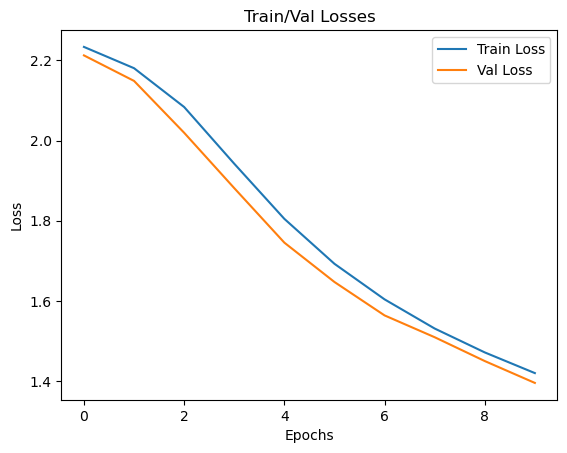

train_losses=[2.233660653622652, 2.1805615035070254, 2.0837404069629497, 1.9422436243927423, 1.8046949668780268, 1.6925317379553013, 1.6038148420106064, 1.5310501313429274, 1.4714441369480802, 1.4198442021364808]
[2.2125044348049747, 2.1488423036651376, 2.0194750980365495, 1.8813365196889162, 1.745328104203464, 1.6471383750804363, 1.5637853820265437, 1.5093587093923722, 1.4498925227329043, 1.395315769259915]
Params lr=0.0001, w=0.01, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 538.44it/s]

Epoch [1 out of 10], Train --> loss: 2.2289 & accuracy: 19.98%, Validation --> loss: 2.1940 & accuracy: 21.84%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 528.02it/s]

Epoch [2 out of 10], Train --> loss: 2.1432 & accuracy: 22.84%, Validation --> loss: 2.0889 & accuracy: 24.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 534.94it/s]

Epoch [3 out of 10], Train --> loss: 2.0299 & accuracy: 26.85%, Validation --> loss: 1.9677 & accuracy: 32.30%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 526.53it/s]

Epoch [4 out of 10], Train --> loss: 1.9027 & accuracy: 33.95%, Validation --> loss: 1.8383 & accuracy: 41.33%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 526.46it/s]

Epoch [5 out of 10], Train --> loss: 1.7790 & accuracy: 40.29%, Validation --> loss: 1.7208 & accuracy: 45.48%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 527.50it/s]

Epoch [6 out of 10], Train --> loss: 1.6792 & accuracy: 45.05%, Validation --> loss: 1.6334 & accuracy: 46.26%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 547.17it/s]

Epoch [7 out of 10], Train --> loss: 1.5973 & accuracy: 49.14%, Validation --> loss: 1.5614 & accuracy: 50.66%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 512.78it/s]

Epoch [8 out of 10], Train --> loss: 1.5280 & accuracy: 52.29%, Validation --> loss: 1.4955 & accuracy: 53.54%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 522.37it/s]

Epoch [9 out of 10], Train --> loss: 1.4690 & accuracy: 54.67%, Validation --> loss: 1.4391 & accuracy: 54.98%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 535.90it/s]

Epoch [10 out of 10], Train --> loss: 1.4163 & accuracy: 56.98%, Validation --> loss: 1.3985 & accuracy: 57.77%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 751.09it/s]


Test Accuracy: 58.22%


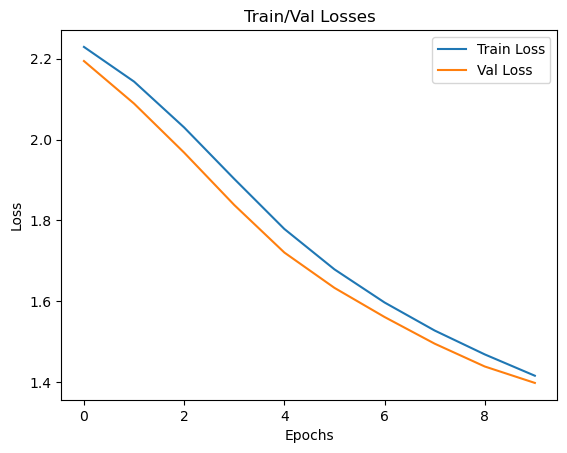

train_losses=[2.2289169589129094, 2.1432349752354365, 2.029887545127107, 1.9027193542083471, 1.7790019127630419, 1.6791606071632579, 1.597293380401834, 1.5280012780437089, 1.4689844262123841, 1.4162694636028483]
[2.194041876705146, 2.0889017059027783, 1.9676660730794895, 1.8382765226568913, 1.720779094227984, 1.633432737888734, 1.561433693016965, 1.495524066540361, 1.4391036748520436, 1.398507796730732]
Params lr=0.001, w=0.0001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 535.22it/s]

Epoch [1 out of 10], Train --> loss: 2.2423 & accuracy: 19.11%, Validation --> loss: 2.2319 & accuracy: 19.82%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 523.42it/s]

Epoch [2 out of 10], Train --> loss: 2.2257 & accuracy: 19.49%, Validation --> loss: 2.2232 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 540.58it/s]

Epoch [3 out of 10], Train --> loss: 2.2217 & accuracy: 19.49%, Validation --> loss: 2.2244 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 490.58it/s]

Epoch [4 out of 10], Train --> loss: 2.2177 & accuracy: 19.49%, Validation --> loss: 2.2288 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 539.60it/s]

Epoch [5 out of 10], Train --> loss: 2.1926 & accuracy: 19.41%, Validation --> loss: 2.1952 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 538.28it/s]

Epoch [6 out of 10], Train --> loss: 2.1709 & accuracy: 18.99%, Validation --> loss: 2.1490 & accuracy: 19.17%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 526.39it/s]

Epoch [7 out of 10], Train --> loss: 2.1626 & accuracy: 18.88%, Validation --> loss: 2.1474 & accuracy: 19.15%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 519.98it/s]

Epoch [8 out of 10], Train --> loss: 2.1602 & accuracy: 18.68%, Validation --> loss: 2.1496 & accuracy: 18.13%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 534.56it/s]

Epoch [9 out of 10], Train --> loss: 2.1557 & accuracy: 18.30%, Validation --> loss: 2.1525 & accuracy: 19.28%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 523.53it/s]

Epoch [10 out of 10], Train --> loss: 2.1545 & accuracy: 18.19%, Validation --> loss: 2.1509 & accuracy: 18.67%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 606.36it/s]


Test Accuracy: 18.49%


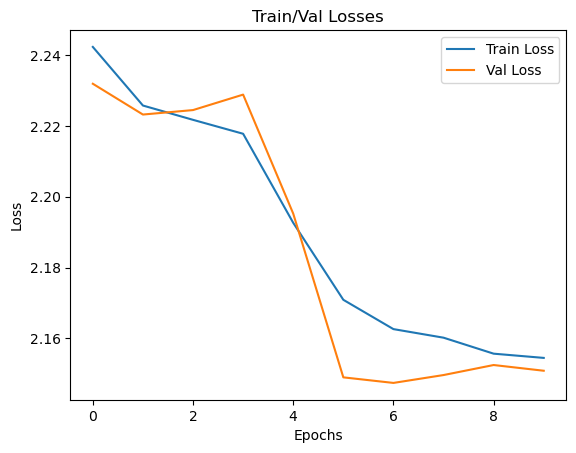

train_losses=[2.2422626644784955, 2.225721558667548, 2.2216823758434407, 2.217749733254657, 2.19261547405782, 2.170886920527562, 2.1626152604955684, 2.160196107836546, 2.1556832215386783, 2.154489180642522]
[2.23186869123962, 2.223176357936274, 2.224438469834123, 2.2288036766959114, 2.195210924543486, 2.149000016823868, 2.1474275175779143, 2.1496492317117797, 2.1524785680273557, 2.150865490085508]
Params lr=0.001, w=0.001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 502.98it/s]

Epoch [1 out of 10], Train --> loss: 2.2207 & accuracy: 19.35%, Validation --> loss: 2.1698 & accuracy: 20.26%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 424.88it/s]

Epoch [2 out of 10], Train --> loss: 2.0803 & accuracy: 23.40%, Validation --> loss: 2.0068 & accuracy: 26.48%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 514.03it/s]

Epoch [3 out of 10], Train --> loss: 1.9925 & accuracy: 26.24%, Validation --> loss: 1.9626 & accuracy: 27.00%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 422.94it/s]

Epoch [4 out of 10], Train --> loss: 1.9603 & accuracy: 26.85%, Validation --> loss: 1.9414 & accuracy: 27.08%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 536.17it/s]

Epoch [5 out of 10], Train --> loss: 1.9445 & accuracy: 27.22%, Validation --> loss: 1.9291 & accuracy: 28.10%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 493.73it/s]

Epoch [6 out of 10], Train --> loss: 1.9353 & accuracy: 27.55%, Validation --> loss: 1.9308 & accuracy: 27.54%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 496.99it/s]

Epoch [7 out of 10], Train --> loss: 1.9306 & accuracy: 27.41%, Validation --> loss: 1.9112 & accuracy: 28.40%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:01<00:00, 179.33it/s]

Epoch [8 out of 10], Train --> loss: 1.9262 & accuracy: 27.64%, Validation --> loss: 1.9037 & accuracy: 28.58%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 495.85it/s]

Epoch [9 out of 10], Train --> loss: 1.9226 & accuracy: 27.82%, Validation --> loss: 1.9559 & accuracy: 26.58%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 487.57it/s]

Epoch [10 out of 10], Train --> loss: 1.9229 & accuracy: 27.39%, Validation --> loss: 1.9184 & accuracy: 26.98%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 736.12it/s]


Test Accuracy: 27.25%


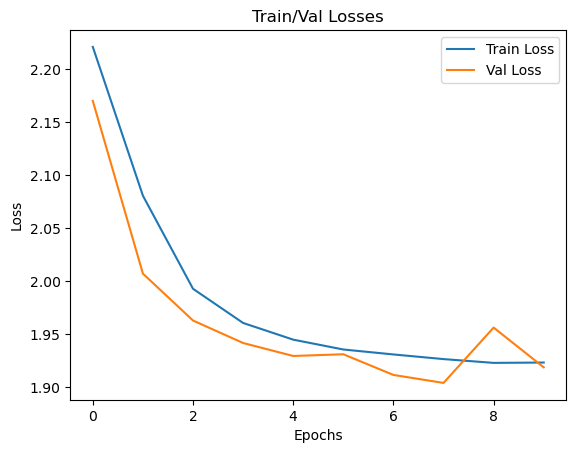

train_losses=[2.220729831634762, 2.0803308516237227, 1.9925173634574527, 1.9602801242182333, 1.9445448263266485, 1.935255337054462, 1.9305855375464245, 1.9261980714153402, 1.922628142134202, 1.9229450876811682]
[2.1697544722469306, 2.0068224562457733, 1.9625805810185297, 1.9413713363050684, 1.9291409996389612, 1.9307620353493953, 1.9112425505017943, 1.9037190489242413, 1.9559328793748025, 1.918424695547373]
Params lr=0.001, w=0.01, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 535.21it/s]

Epoch [1 out of 10], Train --> loss: 2.2348 & accuracy: 19.18%, Validation --> loss: 2.2115 & accuracy: 19.74%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 531.62it/s]

Epoch [2 out of 10], Train --> loss: 2.1177 & accuracy: 21.62%, Validation --> loss: 2.0425 & accuracy: 25.16%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 531.53it/s]

Epoch [3 out of 10], Train --> loss: 1.9869 & accuracy: 26.80%, Validation --> loss: 1.9909 & accuracy: 25.73%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 536.84it/s]

Epoch [4 out of 10], Train --> loss: 1.9441 & accuracy: 28.33%, Validation --> loss: 1.9348 & accuracy: 29.10%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 520.65it/s]

Epoch [5 out of 10], Train --> loss: 1.9300 & accuracy: 28.65%, Validation --> loss: 1.9587 & accuracy: 26.73%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 530.88it/s]

Epoch [6 out of 10], Train --> loss: 1.9220 & accuracy: 29.07%, Validation --> loss: 1.9060 & accuracy: 28.77%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 533.20it/s]

Epoch [7 out of 10], Train --> loss: 1.9153 & accuracy: 28.87%, Validation --> loss: 1.9124 & accuracy: 29.40%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 537.89it/s]

Epoch [8 out of 10], Train --> loss: 1.9143 & accuracy: 29.13%, Validation --> loss: 1.9118 & accuracy: 28.54%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 532.78it/s]

Epoch [9 out of 10], Train --> loss: 1.9113 & accuracy: 28.98%, Validation --> loss: 1.9038 & accuracy: 28.60%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 515.07it/s]

Epoch [10 out of 10], Train --> loss: 1.9076 & accuracy: 28.98%, Validation --> loss: 1.8916 & accuracy: 29.27%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 724.75it/s]


Test Accuracy: 29.31%


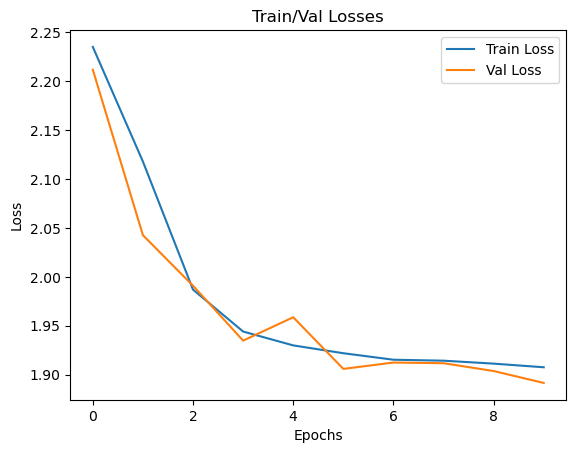

train_losses=[2.234804848555229, 2.1176968118012773, 1.9869089925893442, 1.944112020154153, 1.9299607037948574, 1.9219657446382232, 1.9153325308669364, 1.914345843817598, 1.911333462243439, 1.9076320563776337]
[2.2114834580684732, 2.0424916923411787, 1.9909069479608827, 1.9348375387718342, 1.9587118183176941, 1.9059569842976296, 1.9124441333343647, 1.9117732029751036, 1.9037793563918832, 1.891636050551947]
Params lr=0.01, w=0.0001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 532.45it/s]

Epoch [1 out of 10], Train --> loss: 2.3142 & accuracy: 19.28%, Validation --> loss: 2.2263 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 506.92it/s]

Epoch [2 out of 10], Train --> loss: 2.2247 & accuracy: 19.43%, Validation --> loss: 2.2265 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 522.34it/s]

Epoch [3 out of 10], Train --> loss: 2.2250 & accuracy: 19.49%, Validation --> loss: 2.2236 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 534.63it/s]

Epoch [4 out of 10], Train --> loss: 2.2246 & accuracy: 19.44%, Validation --> loss: 2.2260 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 521.81it/s]

Epoch [5 out of 10], Train --> loss: 2.2243 & accuracy: 19.49%, Validation --> loss: 2.2224 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 539.21it/s]

Epoch [6 out of 10], Train --> loss: 2.2246 & accuracy: 19.49%, Validation --> loss: 2.2224 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 517.27it/s]

Epoch [7 out of 10], Train --> loss: 2.2247 & accuracy: 19.49%, Validation --> loss: 2.2250 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 514.06it/s]

Epoch [8 out of 10], Train --> loss: 2.2246 & accuracy: 19.49%, Validation --> loss: 2.2233 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 515.45it/s]

Epoch [9 out of 10], Train --> loss: 2.2244 & accuracy: 19.49%, Validation --> loss: 2.2230 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 524.97it/s]

Epoch [10 out of 10], Train --> loss: 2.2242 & accuracy: 19.27%, Validation --> loss: 2.2267 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 711.81it/s]


Test Accuracy: 19.59%


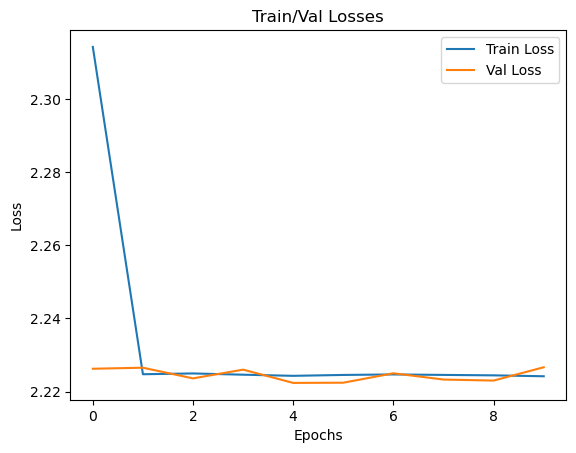

train_losses=[2.3142344780415067, 2.2247477539124025, 2.2249647415544946, 2.2246221158361656, 2.2243125991704096, 2.224554227610704, 2.224692478981985, 2.224562208040885, 2.2244442587807063, 2.22419465128361]
[2.226250194698755, 2.2265308802844554, 2.22361533042112, 2.2260059026852708, 2.2223732822511826, 2.222434073138091, 2.225006480158472, 2.223292603448856, 2.223016540697016, 2.226657175578954]
Params lr=0.01, w=0.001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 525.47it/s]

Epoch [1 out of 10], Train --> loss: 2.3049 & accuracy: 19.11%, Validation --> loss: 2.2234 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 459.74it/s]

Epoch [2 out of 10], Train --> loss: 2.2245 & accuracy: 19.49%, Validation --> loss: 2.2264 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 511.01it/s]

Epoch [3 out of 10], Train --> loss: 2.2251 & accuracy: 19.49%, Validation --> loss: 2.2220 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 491.45it/s]

Epoch [4 out of 10], Train --> loss: 2.2245 & accuracy: 19.41%, Validation --> loss: 2.2228 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 539.56it/s]

Epoch [5 out of 10], Train --> loss: 2.2246 & accuracy: 19.46%, Validation --> loss: 2.2245 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 521.29it/s]

Epoch [6 out of 10], Train --> loss: 2.2246 & accuracy: 19.49%, Validation --> loss: 2.2247 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 536.32it/s]

Epoch [7 out of 10], Train --> loss: 2.2244 & accuracy: 19.49%, Validation --> loss: 2.2244 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 520.81it/s]

Epoch [8 out of 10], Train --> loss: 2.2245 & accuracy: 19.49%, Validation --> loss: 2.2234 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 509.51it/s]

Epoch [9 out of 10], Train --> loss: 2.2248 & accuracy: 19.49%, Validation --> loss: 2.2239 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 529.73it/s]

Epoch [10 out of 10], Train --> loss: 2.2247 & accuracy: 19.41%, Validation --> loss: 2.2239 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 735.96it/s]


Test Accuracy: 19.59%


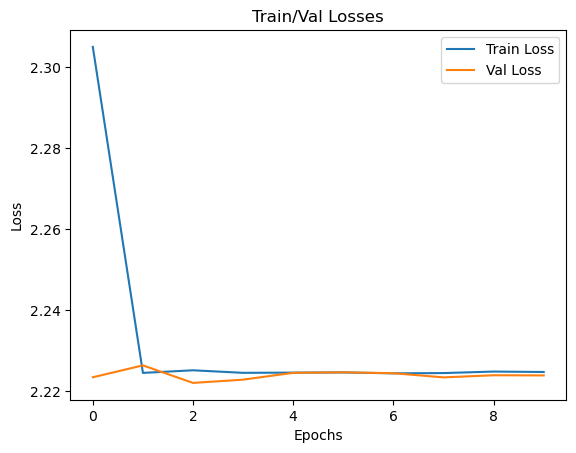

train_losses=[2.3049260282662973, 2.2245070399593465, 2.2251489194490577, 2.2245235236192813, 2.224572983205593, 2.2246212067508844, 2.224393800381691, 2.224462013640162, 2.224834886472529, 2.2247294193039293]
[2.223430885859062, 2.2263567806021567, 2.2220328303933874, 2.222840816331056, 2.2245231340267906, 2.224650640429163, 2.224428907859545, 2.223401624000877, 2.22392312880674, 2.22388431228743]
Params lr=0.01, w=0.01, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 522.44it/s]

Epoch [1 out of 10], Train --> loss: 2.3145 & accuracy: 19.29%, Validation --> loss: 2.2246 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 527.35it/s]

Epoch [2 out of 10], Train --> loss: 2.2247 & accuracy: 19.42%, Validation --> loss: 2.2237 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 534.25it/s]

Epoch [3 out of 10], Train --> loss: 2.2250 & accuracy: 19.49%, Validation --> loss: 2.2246 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 527.09it/s]

Epoch [4 out of 10], Train --> loss: 2.2246 & accuracy: 19.46%, Validation --> loss: 2.2228 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 519.15it/s]

Epoch [5 out of 10], Train --> loss: 2.2250 & accuracy: 19.43%, Validation --> loss: 2.2220 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 523.55it/s]

Epoch [6 out of 10], Train --> loss: 2.2252 & accuracy: 19.49%, Validation --> loss: 2.2228 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 517.40it/s]

Epoch [7 out of 10], Train --> loss: 2.2246 & accuracy: 19.49%, Validation --> loss: 2.2242 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 521.91it/s]

Epoch [8 out of 10], Train --> loss: 2.2249 & accuracy: 19.49%, Validation --> loss: 2.2266 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 527.26it/s]

Epoch [9 out of 10], Train --> loss: 2.2249 & accuracy: 19.49%, Validation --> loss: 2.2288 & accuracy: 15.90%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 510.88it/s]

Epoch [10 out of 10], Train --> loss: 2.2246 & accuracy: 19.36%, Validation --> loss: 2.2238 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 741.89it/s]


Test Accuracy: 19.59%


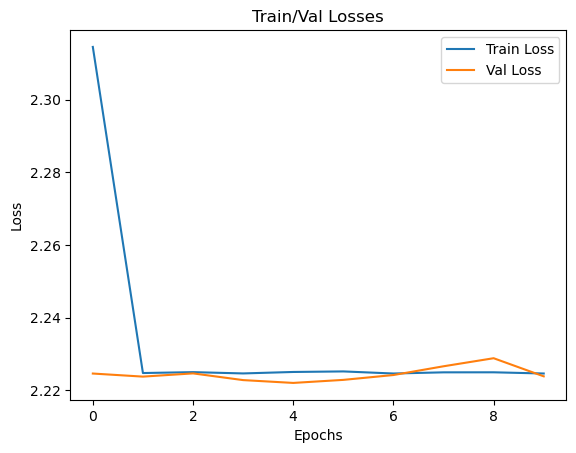

train_losses=[2.3145444978217373, 2.224717852523616, 2.22496413552816, 2.224608432221156, 2.225012180259517, 2.225162800647513, 2.224587107034323, 2.2249102460623886, 2.224920635216064, 2.2245886500713095]
[2.2245796275285126, 2.223732000479669, 2.2246207284049753, 2.2227714972262, 2.2219949854663543, 2.222831845649181, 2.2241699512750825, 2.2265793549502555, 2.228799423191445, 2.2238097863694644]
Params lr=0.0001, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 526.16it/s]

Epoch [1 out of 10], Train --> loss: 2.2396 & accuracy: 19.36%, Validation --> loss: 2.2087 & accuracy: 20.30%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 533.87it/s]

Epoch [2 out of 10], Train --> loss: 2.1571 & accuracy: 23.27%, Validation --> loss: 2.0960 & accuracy: 26.58%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 546.52it/s]

Epoch [3 out of 10], Train --> loss: 1.9978 & accuracy: 31.17%, Validation --> loss: 1.9196 & accuracy: 30.59%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 533.14it/s]

Epoch [4 out of 10], Train --> loss: 1.8121 & accuracy: 39.53%, Validation --> loss: 1.7322 & accuracy: 41.58%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 523.03it/s]

Epoch [5 out of 10], Train --> loss: 1.6652 & accuracy: 46.18%, Validation --> loss: 1.6218 & accuracy: 45.77%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 514.31it/s]

Epoch [6 out of 10], Train --> loss: 1.5558 & accuracy: 50.96%, Validation --> loss: 1.5096 & accuracy: 53.91%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 522.00it/s]

Epoch [7 out of 10], Train --> loss: 1.4692 & accuracy: 54.75%, Validation --> loss: 1.4492 & accuracy: 55.04%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 530.88it/s]

Epoch [8 out of 10], Train --> loss: 1.3996 & accuracy: 57.46%, Validation --> loss: 1.3718 & accuracy: 58.65%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 482.99it/s]

Epoch [9 out of 10], Train --> loss: 1.3446 & accuracy: 59.26%, Validation --> loss: 1.3724 & accuracy: 59.07%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 532.76it/s]

Epoch [10 out of 10], Train --> loss: 1.2980 & accuracy: 61.17%, Validation --> loss: 1.3002 & accuracy: 61.88%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 723.95it/s]


Test Accuracy: 62.42%


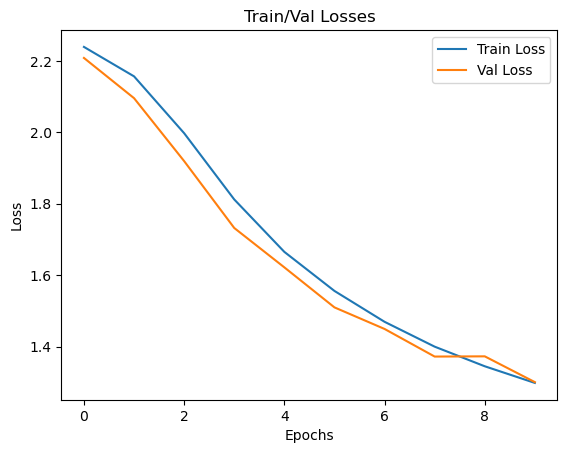

train_losses=[2.23961276319536, 2.157107526713985, 1.9977922018405663, 1.8121232417871327, 1.6652033131243447, 1.5557637868846799, 1.4692468300759334, 1.3996013463825308, 1.3446278806930314, 1.2979552092548523]
[2.2087065047281653, 2.095979581581303, 1.919580517371008, 1.73215692504052, 1.6218067989027574, 1.5096447877357342, 1.4491992422773794, 1.3718310940119387, 1.3724420939120778, 1.3002125860357576]
Params lr=0.0001, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 518.52it/s]

Epoch [1 out of 10], Train --> loss: 2.2374 & accuracy: 19.39%, Validation --> loss: 2.2383 & accuracy: 15.71%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 533.66it/s]

Epoch [2 out of 10], Train --> loss: 2.1647 & accuracy: 23.55%, Validation --> loss: 2.1099 & accuracy: 22.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 515.35it/s]

Epoch [3 out of 10], Train --> loss: 2.0339 & accuracy: 30.17%, Validation --> loss: 1.9496 & accuracy: 33.63%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 509.59it/s]

Epoch [4 out of 10], Train --> loss: 1.8757 & accuracy: 36.95%, Validation --> loss: 1.8361 & accuracy: 38.91%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 496.35it/s]

Epoch [5 out of 10], Train --> loss: 1.7427 & accuracy: 42.39%, Validation --> loss: 1.6831 & accuracy: 43.90%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 514.65it/s]

Epoch [6 out of 10], Train --> loss: 1.6373 & accuracy: 46.76%, Validation --> loss: 1.5988 & accuracy: 48.32%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 543.87it/s]

Epoch [7 out of 10], Train --> loss: 1.5552 & accuracy: 50.28%, Validation --> loss: 1.5285 & accuracy: 50.47%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 526.79it/s]

Epoch [8 out of 10], Train --> loss: 1.4860 & accuracy: 53.26%, Validation --> loss: 1.4600 & accuracy: 53.68%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 533.97it/s]

Epoch [9 out of 10], Train --> loss: 1.4288 & accuracy: 55.68%, Validation --> loss: 1.4131 & accuracy: 55.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 513.05it/s]

Epoch [10 out of 10], Train --> loss: 1.3808 & accuracy: 57.65%, Validation --> loss: 1.3915 & accuracy: 55.85%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 703.18it/s]


Test Accuracy: 56.98%


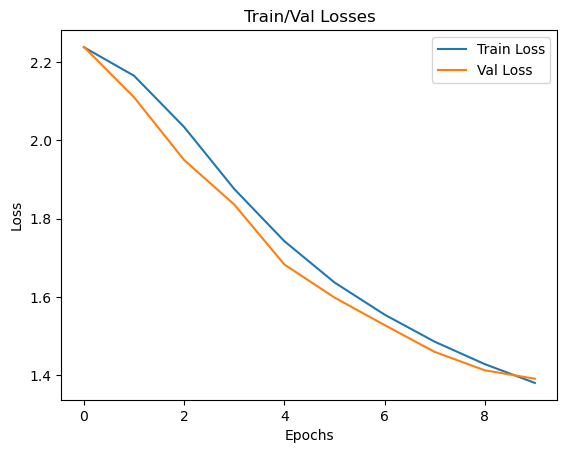

train_losses=[2.237436460185161, 2.164725989057538, 2.033873319992089, 1.8757465865388627, 1.7426554047017604, 1.6372864808538177, 1.5551584722351186, 1.4860430965500493, 1.4288006368595334, 1.3808201740963668]
[2.238313314373508, 2.109862018216607, 1.9496379326457627, 1.8361068649526022, 1.6830579163106674, 1.5987997808339405, 1.5285370039062265, 1.4599834728094698, 1.4130570866578926, 1.3915325788998165]
Params lr=0.0001, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 514.24it/s]

Epoch [1 out of 10], Train --> loss: 2.2352 & accuracy: 18.95%, Validation --> loss: 2.2108 & accuracy: 22.62%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 502.70it/s]

Epoch [2 out of 10], Train --> loss: 2.1764 & accuracy: 21.32%, Validation --> loss: 2.1396 & accuracy: 21.32%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 497.34it/s]

Epoch [3 out of 10], Train --> loss: 2.0829 & accuracy: 25.96%, Validation --> loss: 2.0229 & accuracy: 30.63%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 478.85it/s]

Epoch [4 out of 10], Train --> loss: 1.9646 & accuracy: 31.71%, Validation --> loss: 1.9249 & accuracy: 31.73%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 523.48it/s]

Epoch [5 out of 10], Train --> loss: 1.8553 & accuracy: 36.59%, Validation --> loss: 1.7921 & accuracy: 37.91%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 536.44it/s]

Epoch [6 out of 10], Train --> loss: 1.7643 & accuracy: 41.47%, Validation --> loss: 1.7256 & accuracy: 43.38%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 505.76it/s]

Epoch [7 out of 10], Train --> loss: 1.6912 & accuracy: 45.04%, Validation --> loss: 1.7139 & accuracy: 42.14%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 522.19it/s]

Epoch [8 out of 10], Train --> loss: 1.6341 & accuracy: 46.80%, Validation --> loss: 1.5964 & accuracy: 46.82%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 526.80it/s]

Epoch [9 out of 10], Train --> loss: 1.5854 & accuracy: 49.02%, Validation --> loss: 1.5890 & accuracy: 50.26%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 512.55it/s]

Epoch [10 out of 10], Train --> loss: 1.5424 & accuracy: 50.92%, Validation --> loss: 1.5269 & accuracy: 52.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 731.47it/s]


Test Accuracy: 52.70%


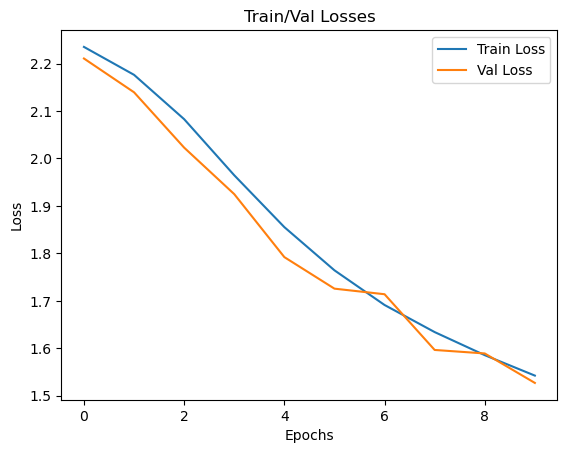

train_losses=[2.235200415924764, 2.176353276966171, 2.082887444444882, 1.9646472817375547, 1.855327035882689, 1.7642892503884897, 1.6912085764602216, 1.6340920477876648, 1.5854474388509303, 1.542356379936734]
[2.210783951487278, 2.1395525211936857, 2.0229109324560577, 1.9248808498031522, 1.792110122420305, 1.7256372154124675, 1.713883214201664, 1.5964279293648305, 1.589035328180512, 1.5269266595504036]
Params lr=0.001, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 477.82it/s]

Epoch [1 out of 10], Train --> loss: 2.2739 & accuracy: 19.77%, Validation --> loss: 2.1528 & accuracy: 23.62%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 507.55it/s]

Epoch [2 out of 10], Train --> loss: 2.0040 & accuracy: 25.19%, Validation --> loss: 1.9294 & accuracy: 25.56%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 512.35it/s]

Epoch [3 out of 10], Train --> loss: 1.8703 & accuracy: 31.47%, Validation --> loss: 1.7884 & accuracy: 36.53%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 536.03it/s]

Epoch [4 out of 10], Train --> loss: 1.7607 & accuracy: 37.15%, Validation --> loss: 1.7257 & accuracy: 37.78%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 526.70it/s]

Epoch [5 out of 10], Train --> loss: 1.7038 & accuracy: 39.45%, Validation --> loss: 1.7415 & accuracy: 38.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 491.64it/s]

Epoch [6 out of 10], Train --> loss: 1.6674 & accuracy: 40.98%, Validation --> loss: 1.7193 & accuracy: 38.81%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 501.35it/s]

Epoch [7 out of 10], Train --> loss: 1.6422 & accuracy: 42.06%, Validation --> loss: 1.7095 & accuracy: 39.08%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 529.36it/s]

Epoch [8 out of 10], Train --> loss: 1.6232 & accuracy: 42.66%, Validation --> loss: 1.6419 & accuracy: 42.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 529.24it/s]

Epoch [9 out of 10], Train --> loss: 1.6086 & accuracy: 43.39%, Validation --> loss: 1.7987 & accuracy: 37.39%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 527.92it/s]

Epoch [10 out of 10], Train --> loss: 1.6007 & accuracy: 43.73%, Validation --> loss: 1.6550 & accuracy: 43.15%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 739.34it/s]


Test Accuracy: 43.56%


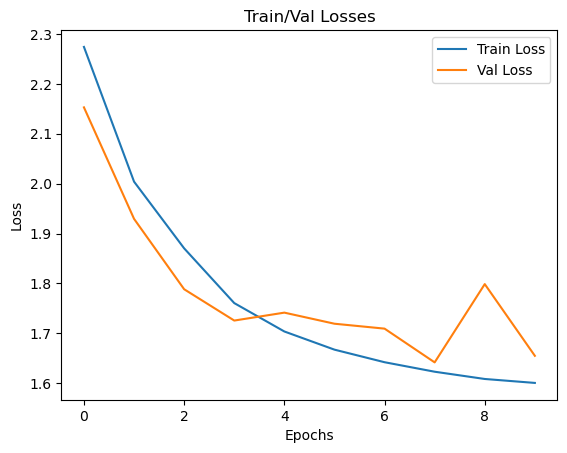

train_losses=[2.2739137677553063, 2.0039765312008777, 1.870338573067602, 1.7606616738022014, 1.703776390779586, 1.6673834305571338, 1.642194396614479, 1.6231641428353416, 1.6086229576218514, 1.6007151906757677]
[2.152802796451592, 1.929444809267126, 1.7884079382463467, 1.7256717166286304, 1.7415424793775827, 1.7193258243835776, 1.7094862552508254, 1.6418683867147363, 1.7986881405663637, 1.6550390005477367]
Params lr=0.001, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 530.21it/s]

Epoch [1 out of 10], Train --> loss: 2.3259 & accuracy: 19.36%, Validation --> loss: 2.1903 & accuracy: 18.13%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 556.43it/s]

Epoch [2 out of 10], Train --> loss: 2.0757 & accuracy: 22.75%, Validation --> loss: 2.0169 & accuracy: 23.79%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 498.85it/s]

Epoch [3 out of 10], Train --> loss: 1.9979 & accuracy: 24.09%, Validation --> loss: 1.9908 & accuracy: 26.73%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 529.36it/s]

Epoch [4 out of 10], Train --> loss: 1.9259 & accuracy: 27.07%, Validation --> loss: 1.8685 & accuracy: 29.69%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 535.09it/s]

Epoch [5 out of 10], Train --> loss: 1.8845 & accuracy: 28.61%, Validation --> loss: 1.8760 & accuracy: 28.79%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 521.74it/s]

Epoch [6 out of 10], Train --> loss: 1.8461 & accuracy: 31.05%, Validation --> loss: 1.7923 & accuracy: 33.69%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 501.91it/s]

Epoch [7 out of 10], Train --> loss: 1.7983 & accuracy: 34.59%, Validation --> loss: 1.7096 & accuracy: 40.00%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 509.39it/s]

Epoch [8 out of 10], Train --> loss: 1.7318 & accuracy: 38.83%, Validation --> loss: 1.7220 & accuracy: 40.56%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 505.80it/s]

Epoch [9 out of 10], Train --> loss: 1.7079 & accuracy: 40.26%, Validation --> loss: 1.6891 & accuracy: 39.60%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 507.47it/s]

Epoch [10 out of 10], Train --> loss: 1.6931 & accuracy: 40.47%, Validation --> loss: 1.6346 & accuracy: 44.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 736.56it/s]


Test Accuracy: 43.78%


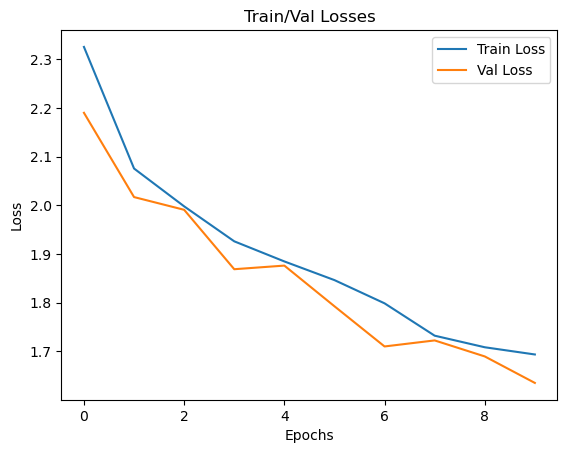

train_losses=[2.325878334851126, 2.075682321268659, 1.9978617802376755, 1.925898472742734, 1.8845214048105816, 1.8461118816596938, 1.7983337321222836, 1.7317765163752707, 1.7079428897658435, 1.693091183122585]
[2.1903030938166053, 2.0169463622058097, 1.990763771387697, 1.8685190516746848, 1.8759678989831656, 1.7922652846465081, 1.709589960384954, 1.7220180133369072, 1.6890773588528663, 1.6345680855168887]
Params lr=0.001, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 537.30it/s]

Epoch [1 out of 10], Train --> loss: 2.3003 & accuracy: 18.90%, Validation --> loss: 2.1818 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 537.04it/s]

Epoch [2 out of 10], Train --> loss: 2.1603 & accuracy: 19.79%, Validation --> loss: 2.1713 & accuracy: 19.93%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 531.29it/s]

Epoch [3 out of 10], Train --> loss: 2.1126 & accuracy: 20.34%, Validation --> loss: 2.0675 & accuracy: 20.07%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 512.99it/s]

Epoch [4 out of 10], Train --> loss: 2.0884 & accuracy: 21.77%, Validation --> loss: 2.0596 & accuracy: 22.87%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 504.40it/s]

Epoch [5 out of 10], Train --> loss: 2.0812 & accuracy: 21.71%, Validation --> loss: 2.0723 & accuracy: 20.97%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 514.72it/s]

Epoch [6 out of 10], Train --> loss: 2.0764 & accuracy: 21.77%, Validation --> loss: 2.0735 & accuracy: 22.70%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 525.65it/s]

Epoch [7 out of 10], Train --> loss: 2.0742 & accuracy: 21.60%, Validation --> loss: 2.0876 & accuracy: 22.35%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 511.48it/s]

Epoch [8 out of 10], Train --> loss: 2.0681 & accuracy: 21.71%, Validation --> loss: 2.0837 & accuracy: 20.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 514.77it/s]

Epoch [9 out of 10], Train --> loss: 2.0700 & accuracy: 21.76%, Validation --> loss: 2.1408 & accuracy: 19.57%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 547.78it/s]

Epoch [10 out of 10], Train --> loss: 2.0665 & accuracy: 21.78%, Validation --> loss: 2.1460 & accuracy: 18.65%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 738.69it/s]


Test Accuracy: 19.03%


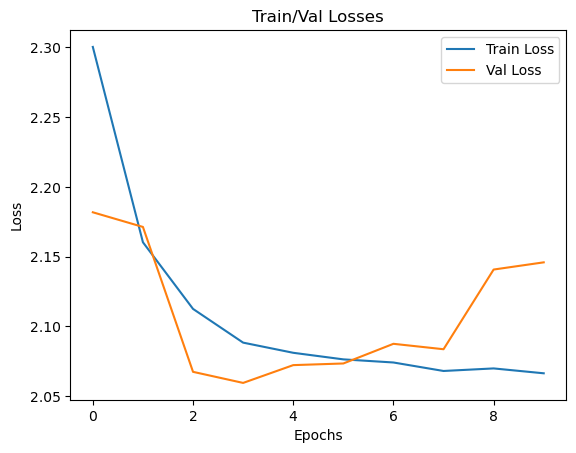

train_losses=[2.3002764934218973, 2.16034249125904, 2.1125946398338047, 2.088439520511393, 2.0811607017312, 2.0764492252089095, 2.0742146548587606, 2.0681332341536947, 2.069961092072881, 2.066470518914236]
[2.1818159902754006, 2.171311955510473, 2.0675172498621093, 2.059574974460836, 2.0723249787933256, 2.073500978800417, 2.087594127362491, 2.0837113264879568, 2.1407939181006026, 2.1459545207901236]
Params lr=0.01, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 530.23it/s]

Epoch [1 out of 10], Train --> loss: 5.0909 & accuracy: 19.08%, Validation --> loss: 2.2264 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 514.06it/s]

Epoch [2 out of 10], Train --> loss: 2.3712 & accuracy: 19.34%, Validation --> loss: 2.2264 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 508.88it/s]

Epoch [3 out of 10], Train --> loss: 2.2799 & accuracy: 19.49%, Validation --> loss: 2.2248 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 517.89it/s]

Epoch [4 out of 10], Train --> loss: 2.2312 & accuracy: 19.49%, Validation --> loss: 2.2234 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 515.19it/s]

Epoch [5 out of 10], Train --> loss: 2.2246 & accuracy: 19.49%, Validation --> loss: 2.2235 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 552.73it/s]

Epoch [6 out of 10], Train --> loss: 2.2248 & accuracy: 19.49%, Validation --> loss: 2.2247 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 525.84it/s]

Epoch [7 out of 10], Train --> loss: 2.2249 & accuracy: 19.49%, Validation --> loss: 2.2258 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 532.38it/s]

Epoch [8 out of 10], Train --> loss: 2.2247 & accuracy: 19.49%, Validation --> loss: 2.2256 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 515.38it/s]

Epoch [9 out of 10], Train --> loss: 2.2250 & accuracy: 19.46%, Validation --> loss: 2.2240 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 533.02it/s]

Epoch [10 out of 10], Train --> loss: 2.2245 & accuracy: 19.46%, Validation --> loss: 2.2249 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 727.78it/s]


Test Accuracy: 19.59%


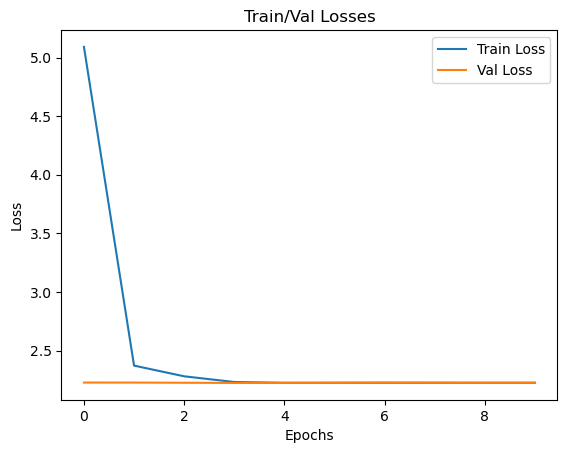

train_losses=[5.090935988634962, 2.371222673015477, 2.2798504431126854, 2.231202463034294, 2.224604483024316, 2.224805898655395, 2.2249303645069514, 2.224663025223165, 2.22498353130074, 2.224527653644345]
[2.226449391593231, 2.2263918515363352, 2.2247558930900198, 2.223372315702263, 2.2235023818133066, 2.224716290374475, 2.225762160643478, 2.2255568186198276, 2.2240103336931005, 2.224923726971164]
Params lr=0.01, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 513.08it/s]

Epoch [1 out of 10], Train --> loss: 5.1365 & accuracy: 18.61%, Validation --> loss: 2.2276 & accuracy: 15.90%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 527.45it/s]

Epoch [2 out of 10], Train --> loss: 2.2900 & accuracy: 19.21%, Validation --> loss: 2.2236 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 525.17it/s]

Epoch [3 out of 10], Train --> loss: 2.2246 & accuracy: 19.47%, Validation --> loss: 2.2236 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 550.28it/s]

Epoch [4 out of 10], Train --> loss: 2.2246 & accuracy: 19.43%, Validation --> loss: 2.2219 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 553.07it/s]

Epoch [5 out of 10], Train --> loss: 2.2247 & accuracy: 19.40%, Validation --> loss: 2.2235 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 515.14it/s]

Epoch [6 out of 10], Train --> loss: 2.2248 & accuracy: 19.36%, Validation --> loss: 2.2259 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 511.28it/s]

Epoch [7 out of 10], Train --> loss: 2.2247 & accuracy: 19.49%, Validation --> loss: 2.2235 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 534.26it/s]

Epoch [8 out of 10], Train --> loss: 2.2242 & accuracy: 19.45%, Validation --> loss: 2.2229 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 501.07it/s]

Epoch [9 out of 10], Train --> loss: 2.2246 & accuracy: 19.48%, Validation --> loss: 2.2263 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 518.59it/s]

Epoch [10 out of 10], Train --> loss: 2.2248 & accuracy: 19.45%, Validation --> loss: 2.2231 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 634.74it/s]


Test Accuracy: 19.59%


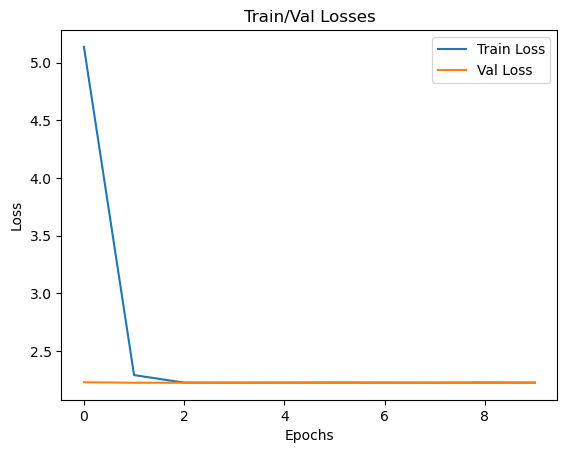

train_losses=[5.1364710883977045, 2.2899567278848814, 2.2245810376151183, 2.2246228462906292, 2.224743119216368, 2.224754005716327, 2.2246879531491186, 2.2241678567525978, 2.224641989819282, 2.2247753522363127]
[2.227583233564178, 2.223612383830767, 2.2235988868526153, 2.2219482755368474, 2.2234704201938182, 2.225934643321242, 2.2235190389346493, 2.2229197222762314, 2.22633485852575, 2.223128847549298]
Params lr=0.01, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 537.46it/s]

Epoch [1 out of 10], Train --> loss: 4.7618 & accuracy: 18.14%, Validation --> loss: 2.2238 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 496.61it/s]

Epoch [2 out of 10], Train --> loss: 2.2248 & accuracy: 19.46%, Validation --> loss: 2.2249 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 513.66it/s]

Epoch [3 out of 10], Train --> loss: 2.2250 & accuracy: 19.42%, Validation --> loss: 2.2227 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 502.60it/s]

Epoch [4 out of 10], Train --> loss: 2.2252 & accuracy: 19.49%, Validation --> loss: 2.2263 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 508.82it/s]

Epoch [5 out of 10], Train --> loss: 2.2248 & accuracy: 19.49%, Validation --> loss: 2.2233 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 521.23it/s]

Epoch [6 out of 10], Train --> loss: 2.2252 & accuracy: 19.49%, Validation --> loss: 2.2232 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 507.33it/s]

Epoch [7 out of 10], Train --> loss: 2.2245 & accuracy: 19.35%, Validation --> loss: 2.2264 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 478.64it/s]

Epoch [8 out of 10], Train --> loss: 2.2250 & accuracy: 19.48%, Validation --> loss: 2.2239 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 512.31it/s]

Epoch [9 out of 10], Train --> loss: 2.2249 & accuracy: 19.49%, Validation --> loss: 2.2251 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 509.80it/s]

Epoch [10 out of 10], Train --> loss: 2.2249 & accuracy: 19.49%, Validation --> loss: 2.2229 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 704.37it/s]


Test Accuracy: 19.59%


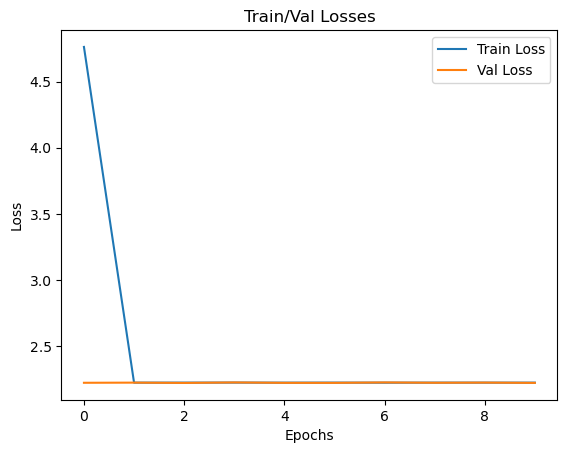

train_losses=[4.761811347051699, 2.2248479170000866, 2.2250280790431525, 2.2252115788547675, 2.2248029914869143, 2.225176207023099, 2.224452640420647, 2.225028422662556, 2.224946636666534, 2.2249324817994407]
[2.2237729422885217, 2.224879671459549, 2.2227064151705407, 2.2263127890832584, 2.2233308129515383, 2.2231781318143833, 2.2264178589077814, 2.223926857570929, 2.225096424298784, 2.222942761848309]


In [14]:
res = train_grid_search(params=params, bn=False, num_epochs=num_epochs, results=res)

In [15]:
res

,optimizer,accuracy,learning_rate,weight_decay
0,Adam,0.541195,0.0001,0.0001
0,Adam,0.587286,0.0001,0.0010
0,Adam,0.577684,0.0001,0.0100
0,Adam,0.199923,0.0010,0.0001
0,Adam,0.285769,0.0010,0.0010
0,Adam,0.294027,0.0010,0.0100
0,Adam,0.199923,0.0100,0.0001
0,Adam,0.199923,0.0100,0.0010
0,Adam,0.199923,0.0100,0.0100
0,RMSprop,0.618782,0.0001,0.0001


## Дообучение

Выберем 3 лучшие модели и попытаемся обучить модель с большим количеством эпох для получения лучших результатов. По графикам это представляется возможным, выход на плато не достигнут.

In [31]:
best_top_3_res = res.sort_values(by=['accuracy'], ascending=False)[:3]

def get_optim(x):
    if x == 'Adam':
        return Adam
    
    return optim.RMSprop

params = []
for opt, _, lr, w in best_top_3_res.values:
    params += [(get_optim(opt), lr, w)]

In [32]:
params

[(torch.optim.rmsprop.RMSprop, 0.0001, 0.0001),
 (my_adam.Adam, 0.0001, 0.001),
 (my_adam.Adam, 0.0001, 0.01)]

Params lr=0.0001, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 359.29it/s]

Epoch [1 out of 50], Train --> loss: 2.2349 & accuracy: 18.89%, Validation --> loss: 2.2083 & accuracy: 20.24%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 449.00it/s]

Epoch [2 out of 50], Train --> loss: 2.1568 & accuracy: 22.75%, Validation --> loss: 2.0916 & accuracy: 22.47%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 549.89it/s]

Epoch [3 out of 50], Train --> loss: 1.9939 & accuracy: 30.33%, Validation --> loss: 1.9260 & accuracy: 39.68%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 532.05it/s]

Epoch [4 out of 50], Train --> loss: 1.8119 & accuracy: 39.16%, Validation --> loss: 1.7422 & accuracy: 40.08%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 543.43it/s]

Epoch [5 out of 50], Train --> loss: 1.6719 & accuracy: 45.20%, Validation --> loss: 1.5984 & accuracy: 48.42%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 533.62it/s]

Epoch [6 out of 50], Train --> loss: 1.5677 & accuracy: 50.09%, Validation --> loss: 1.5195 & accuracy: 52.35%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 510.14it/s]

Epoch [7 out of 50], Train --> loss: 1.4883 & accuracy: 53.58%, Validation --> loss: 1.4719 & accuracy: 52.56%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 548.33it/s]

Epoch [8 out of 50], Train --> loss: 1.4211 & accuracy: 56.24%, Validation --> loss: 1.4459 & accuracy: 53.24%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 542.59it/s]

Epoch [9 out of 50], Train --> loss: 1.3661 & accuracy: 59.09%, Validation --> loss: 1.3584 & accuracy: 59.52%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 530.17it/s]

Epoch [10 out of 50], Train --> loss: 1.3176 & accuracy: 60.60%, Validation --> loss: 1.2931 & accuracy: 61.97%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.81it/s]

Epoch [11 out of 50], Train --> loss: 1.2723 & accuracy: 62.04%, Validation --> loss: 1.3033 & accuracy: 59.63%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 566.44it/s]

Epoch [12 out of 50], Train --> loss: 1.2381 & accuracy: 63.12%, Validation --> loss: 1.2313 & accuracy: 64.16%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 541.29it/s]

Epoch [13 out of 50], Train --> loss: 1.2037 & accuracy: 64.44%, Validation --> loss: 1.2444 & accuracy: 62.92%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 548.82it/s]

Epoch [14 out of 50], Train --> loss: 1.1716 & accuracy: 65.33%, Validation --> loss: 1.1843 & accuracy: 63.70%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 549.59it/s]

Epoch [15 out of 50], Train --> loss: 1.1461 & accuracy: 66.18%, Validation --> loss: 1.1407 & accuracy: 66.41%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 530.70it/s]

Epoch [16 out of 50], Train --> loss: 1.1203 & accuracy: 67.01%, Validation --> loss: 1.1434 & accuracy: 65.32%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 539.31it/s]

Epoch [17 out of 50], Train --> loss: 1.0969 & accuracy: 67.70%, Validation --> loss: 1.1182 & accuracy: 67.77%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 528.76it/s]

Epoch [18 out of 50], Train --> loss: 1.0785 & accuracy: 68.13%, Validation --> loss: 1.0838 & accuracy: 68.70%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 554.48it/s]

Epoch [19 out of 50], Train --> loss: 1.0598 & accuracy: 68.91%, Validation --> loss: 1.0921 & accuracy: 68.18%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 575.83it/s]

Epoch [20 out of 50], Train --> loss: 1.0409 & accuracy: 69.31%, Validation --> loss: 1.0844 & accuracy: 68.10%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 554.47it/s]

Epoch [21 out of 50], Train --> loss: 1.0254 & accuracy: 70.03%, Validation --> loss: 1.0487 & accuracy: 68.66%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 556.76it/s]

Epoch [22 out of 50], Train --> loss: 1.0086 & accuracy: 70.17%, Validation --> loss: 1.0294 & accuracy: 70.44%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 563.00it/s]

Epoch [23 out of 50], Train --> loss: 0.9945 & accuracy: 70.81%, Validation --> loss: 1.0806 & accuracy: 67.31%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 562.09it/s]

Epoch [24 out of 50], Train --> loss: 0.9805 & accuracy: 71.04%, Validation --> loss: 0.9982 & accuracy: 71.14%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 473.98it/s]

Epoch [25 out of 50], Train --> loss: 0.9653 & accuracy: 71.49%, Validation --> loss: 1.0009 & accuracy: 71.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 529.06it/s]

Epoch [26 out of 50], Train --> loss: 0.9543 & accuracy: 72.03%, Validation --> loss: 1.0015 & accuracy: 70.98%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 493.06it/s]

Epoch [27 out of 50], Train --> loss: 0.9402 & accuracy: 72.61%, Validation --> loss: 0.9717 & accuracy: 71.98%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 552.60it/s]

Epoch [28 out of 50], Train --> loss: 0.9298 & accuracy: 72.49%, Validation --> loss: 0.9757 & accuracy: 71.98%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 550.48it/s]

Epoch [29 out of 50], Train --> loss: 0.9176 & accuracy: 73.21%, Validation --> loss: 0.9656 & accuracy: 71.86%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 553.29it/s]

Epoch [30 out of 50], Train --> loss: 0.9072 & accuracy: 73.13%, Validation --> loss: 0.9746 & accuracy: 71.29%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 539.16it/s]

Epoch [31 out of 50], Train --> loss: 0.8949 & accuracy: 73.72%, Validation --> loss: 0.9693 & accuracy: 71.63%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 513.51it/s]

Epoch [32 out of 50], Train --> loss: 0.8852 & accuracy: 73.71%, Validation --> loss: 0.9431 & accuracy: 72.88%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 537.26it/s]

Epoch [33 out of 50], Train --> loss: 0.8746 & accuracy: 74.42%, Validation --> loss: 0.9507 & accuracy: 72.40%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 452.98it/s]

Epoch [34 out of 50], Train --> loss: 0.8635 & accuracy: 74.59%, Validation --> loss: 0.9388 & accuracy: 72.98%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 562.13it/s]

Epoch [35 out of 50], Train --> loss: 0.8553 & accuracy: 74.76%, Validation --> loss: 0.9180 & accuracy: 73.15%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 534.77it/s]

Epoch [36 out of 50], Train --> loss: 0.8473 & accuracy: 74.95%, Validation --> loss: 0.8998 & accuracy: 74.17%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 542.19it/s]

Epoch [37 out of 50], Train --> loss: 0.8379 & accuracy: 75.17%, Validation --> loss: 0.9007 & accuracy: 74.40%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 547.36it/s]

Epoch [38 out of 50], Train --> loss: 0.8284 & accuracy: 75.55%, Validation --> loss: 0.9796 & accuracy: 70.46%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 550.19it/s]

Epoch [39 out of 50], Train --> loss: 0.8206 & accuracy: 75.56%, Validation --> loss: 0.8943 & accuracy: 74.00%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 534.89it/s]

Epoch [40 out of 50], Train --> loss: 0.8118 & accuracy: 75.99%, Validation --> loss: 0.8788 & accuracy: 74.55%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 539.24it/s]

Epoch [41 out of 50], Train --> loss: 0.8033 & accuracy: 76.31%, Validation --> loss: 0.9193 & accuracy: 72.29%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 550.56it/s]

Epoch [42 out of 50], Train --> loss: 0.7961 & accuracy: 76.66%, Validation --> loss: 0.8700 & accuracy: 74.50%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 509.38it/s]

Epoch [43 out of 50], Train --> loss: 0.7891 & accuracy: 76.61%, Validation --> loss: 0.8736 & accuracy: 74.69%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 482.81it/s]

Epoch [44 out of 50], Train --> loss: 0.7820 & accuracy: 76.97%, Validation --> loss: 0.8876 & accuracy: 74.30%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 535.55it/s]

Epoch [45 out of 50], Train --> loss: 0.7758 & accuracy: 77.35%, Validation --> loss: 0.8838 & accuracy: 73.82%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 549.95it/s]

Epoch [46 out of 50], Train --> loss: 0.7666 & accuracy: 77.58%, Validation --> loss: 0.8711 & accuracy: 73.82%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 532.92it/s]

Epoch [47 out of 50], Train --> loss: 0.7606 & accuracy: 77.38%, Validation --> loss: 0.8967 & accuracy: 73.52%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 573.93it/s]

Epoch [48 out of 50], Train --> loss: 0.7548 & accuracy: 77.69%, Validation --> loss: 0.8369 & accuracy: 75.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 564.00it/s]

Epoch [49 out of 50], Train --> loss: 0.7485 & accuracy: 78.14%, Validation --> loss: 0.8310 & accuracy: 76.03%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 540.24it/s]

Epoch [50 out of 50], Train --> loss: 0.7417 & accuracy: 78.32%, Validation --> loss: 0.8234 & accuracy: 76.32%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 784.65it/s]


Test Accuracy: 78.51%


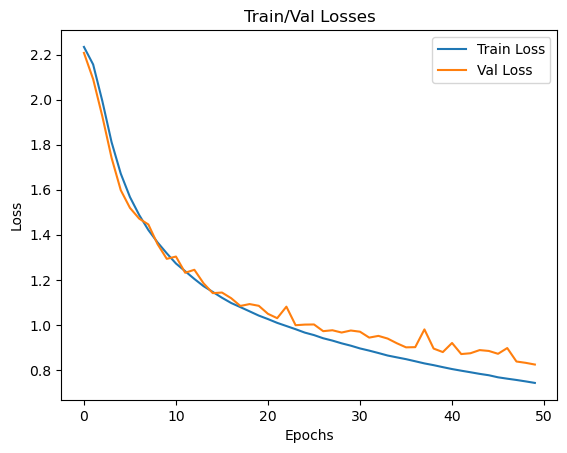

train_losses=[2.2348574237889407, 2.1567952769326357, 1.9939459716120074, 1.8119261938672278, 1.6718583983210376, 1.5676864494559586, 1.4882605488765441, 1.4211455613328932, 1.3660952167760025, 1.3176093168797032, 1.2723413212782777, 1.238096301090516, 1.2037102560614295, 1.1716426452092494, 1.146112362269066, 1.1202617896042661, 1.0968763940436865, 1.0785319612414423, 1.0597787298685577, 1.0409288551492442, 1.0253716340537444, 1.0086074866091235, 0.9945245911403002, 0.980473212542988, 0.9653096213341675, 0.9542601721306917, 0.9401667485108024, 0.9298214055655006, 0.9176479591523081, 0.9071889734854164, 0.8949331378309591, 0.8852387735714561, 0.8745829536709734, 0.8634679779273025, 0.8553074107214969, 0.8473224373228173, 0.8379484788785058, 0.8284137382554019, 0.8206203784078314, 0.8117816012907779, 0.8033343118410873, 0.7960542827707282, 0.7891293979391524, 0.7819527145103192, 0.7758124581839998, 0.7666197191185665, 0.7605508267765038, 0.7548358604174605, 0.7485074822071327, 0.7417079

100%|██████████| 326/326 [00:00<00:00, 548.73it/s]

Epoch [1 out of 50], Train --> loss: 2.2366 & accuracy: 18.97%, Validation --> loss: 2.2110 & accuracy: 21.62%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 541.76it/s]

Epoch [2 out of 50], Train --> loss: 2.1571 & accuracy: 23.12%, Validation --> loss: 2.0979 & accuracy: 24.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 545.23it/s]

Epoch [3 out of 50], Train --> loss: 2.0175 & accuracy: 30.12%, Validation --> loss: 1.9528 & accuracy: 35.70%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 538.01it/s]

Epoch [4 out of 50], Train --> loss: 1.8600 & accuracy: 37.15%, Validation --> loss: 1.7820 & accuracy: 39.98%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 543.83it/s]

Epoch [5 out of 50], Train --> loss: 1.7261 & accuracy: 43.14%, Validation --> loss: 1.6751 & accuracy: 43.15%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 540.62it/s]

Epoch [6 out of 50], Train --> loss: 1.6228 & accuracy: 47.61%, Validation --> loss: 1.5812 & accuracy: 48.34%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 558.75it/s]

Epoch [7 out of 50], Train --> loss: 1.5424 & accuracy: 51.18%, Validation --> loss: 1.5077 & accuracy: 54.02%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 533.90it/s]

Epoch [8 out of 50], Train --> loss: 1.4778 & accuracy: 53.92%, Validation --> loss: 1.4502 & accuracy: 54.83%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 561.66it/s]

Epoch [9 out of 50], Train --> loss: 1.4223 & accuracy: 56.24%, Validation --> loss: 1.4383 & accuracy: 57.13%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 554.77it/s]

Epoch [10 out of 50], Train --> loss: 1.3729 & accuracy: 58.25%, Validation --> loss: 1.3850 & accuracy: 56.17%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 545.29it/s]

Epoch [11 out of 50], Train --> loss: 1.3296 & accuracy: 59.77%, Validation --> loss: 1.3201 & accuracy: 60.55%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 428.98it/s]

Epoch [12 out of 50], Train --> loss: 1.2934 & accuracy: 60.80%, Validation --> loss: 1.2845 & accuracy: 61.07%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 481.75it/s]

Epoch [13 out of 50], Train --> loss: 1.2602 & accuracy: 62.25%, Validation --> loss: 1.2573 & accuracy: 62.07%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 567.06it/s]

Epoch [14 out of 50], Train --> loss: 1.2288 & accuracy: 63.15%, Validation --> loss: 1.2274 & accuracy: 64.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 564.63it/s]

Epoch [15 out of 50], Train --> loss: 1.2025 & accuracy: 64.02%, Validation --> loss: 1.1944 & accuracy: 64.07%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 553.91it/s]

Epoch [16 out of 50], Train --> loss: 1.1807 & accuracy: 64.79%, Validation --> loss: 1.1843 & accuracy: 65.10%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 484.44it/s]

Epoch [17 out of 50], Train --> loss: 1.1586 & accuracy: 65.65%, Validation --> loss: 1.1844 & accuracy: 64.37%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 546.95it/s]

Epoch [18 out of 50], Train --> loss: 1.1395 & accuracy: 65.96%, Validation --> loss: 1.1718 & accuracy: 65.53%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 560.71it/s]

Epoch [19 out of 50], Train --> loss: 1.1196 & accuracy: 66.42%, Validation --> loss: 1.1605 & accuracy: 66.31%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 557.89it/s]

Epoch [20 out of 50], Train --> loss: 1.1044 & accuracy: 67.50%, Validation --> loss: 1.1062 & accuracy: 67.79%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 529.10it/s]

Epoch [21 out of 50], Train --> loss: 1.0881 & accuracy: 67.70%, Validation --> loss: 1.1078 & accuracy: 67.47%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 549.28it/s]

Epoch [22 out of 50], Train --> loss: 1.0722 & accuracy: 68.30%, Validation --> loss: 1.0854 & accuracy: 68.60%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 527.17it/s]

Epoch [23 out of 50], Train --> loss: 1.0602 & accuracy: 68.63%, Validation --> loss: 1.0763 & accuracy: 68.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 544.21it/s]

Epoch [24 out of 50], Train --> loss: 1.0452 & accuracy: 69.05%, Validation --> loss: 1.0702 & accuracy: 69.16%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 549.95it/s]

Epoch [25 out of 50], Train --> loss: 1.0347 & accuracy: 69.37%, Validation --> loss: 1.0945 & accuracy: 67.62%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 536.52it/s]

Epoch [26 out of 50], Train --> loss: 1.0234 & accuracy: 69.94%, Validation --> loss: 1.0841 & accuracy: 68.60%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 534.07it/s]

Epoch [27 out of 50], Train --> loss: 1.0126 & accuracy: 70.09%, Validation --> loss: 1.0538 & accuracy: 68.91%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 556.68it/s]

Epoch [28 out of 50], Train --> loss: 0.9994 & accuracy: 70.43%, Validation --> loss: 1.0378 & accuracy: 69.50%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 532.02it/s]

Epoch [29 out of 50], Train --> loss: 0.9905 & accuracy: 70.75%, Validation --> loss: 1.0166 & accuracy: 70.85%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 437.02it/s]

Epoch [30 out of 50], Train --> loss: 0.9816 & accuracy: 70.92%, Validation --> loss: 1.0348 & accuracy: 69.54%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 555.28it/s]

Epoch [31 out of 50], Train --> loss: 0.9718 & accuracy: 71.17%, Validation --> loss: 1.0181 & accuracy: 70.46%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 526.25it/s]

Epoch [32 out of 50], Train --> loss: 0.9612 & accuracy: 71.51%, Validation --> loss: 1.0464 & accuracy: 69.50%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 534.30it/s]

Epoch [33 out of 50], Train --> loss: 0.9531 & accuracy: 72.11%, Validation --> loss: 1.0166 & accuracy: 69.60%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 420.67it/s]

Epoch [34 out of 50], Train --> loss: 0.9423 & accuracy: 72.29%, Validation --> loss: 0.9837 & accuracy: 71.81%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 520.38it/s]

Epoch [35 out of 50], Train --> loss: 0.9341 & accuracy: 72.52%, Validation --> loss: 0.9845 & accuracy: 71.75%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 543.42it/s]

Epoch [36 out of 50], Train --> loss: 0.9289 & accuracy: 72.56%, Validation --> loss: 0.9690 & accuracy: 72.46%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 527.05it/s]

Epoch [37 out of 50], Train --> loss: 0.9203 & accuracy: 72.89%, Validation --> loss: 0.9743 & accuracy: 72.02%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 448.58it/s]

Epoch [38 out of 50], Train --> loss: 0.9138 & accuracy: 73.11%, Validation --> loss: 0.9746 & accuracy: 72.17%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 543.94it/s]

Epoch [39 out of 50], Train --> loss: 0.9041 & accuracy: 73.49%, Validation --> loss: 0.9638 & accuracy: 72.42%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 536.40it/s]

Epoch [40 out of 50], Train --> loss: 0.8972 & accuracy: 73.83%, Validation --> loss: 0.9459 & accuracy: 73.07%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 542.55it/s]

Epoch [41 out of 50], Train --> loss: 0.8901 & accuracy: 73.66%, Validation --> loss: 0.9478 & accuracy: 72.13%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 492.20it/s]

Epoch [42 out of 50], Train --> loss: 0.8828 & accuracy: 74.03%, Validation --> loss: 0.9397 & accuracy: 72.81%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 542.19it/s]

Epoch [43 out of 50], Train --> loss: 0.8776 & accuracy: 74.21%, Validation --> loss: 0.9394 & accuracy: 73.55%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 545.02it/s]

Epoch [44 out of 50], Train --> loss: 0.8698 & accuracy: 74.30%, Validation --> loss: 0.9504 & accuracy: 72.29%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 540.02it/s]

Epoch [45 out of 50], Train --> loss: 0.8649 & accuracy: 74.43%, Validation --> loss: 0.9460 & accuracy: 73.15%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 542.66it/s]

Epoch [46 out of 50], Train --> loss: 0.8586 & accuracy: 74.57%, Validation --> loss: 0.9288 & accuracy: 73.50%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 553.24it/s]

Epoch [47 out of 50], Train --> loss: 0.8567 & accuracy: 74.75%, Validation --> loss: 0.9322 & accuracy: 73.31%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 552.72it/s]

Epoch [48 out of 50], Train --> loss: 0.8534 & accuracy: 74.96%, Validation --> loss: 0.9255 & accuracy: 73.63%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 553.59it/s]

Epoch [49 out of 50], Train --> loss: 0.8436 & accuracy: 75.13%, Validation --> loss: 0.9233 & accuracy: 73.50%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 531.86it/s]

Epoch [50 out of 50], Train --> loss: 0.8387 & accuracy: 75.46%, Validation --> loss: 0.9439 & accuracy: 72.23%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 641.41it/s]


Test Accuracy: 74.31%


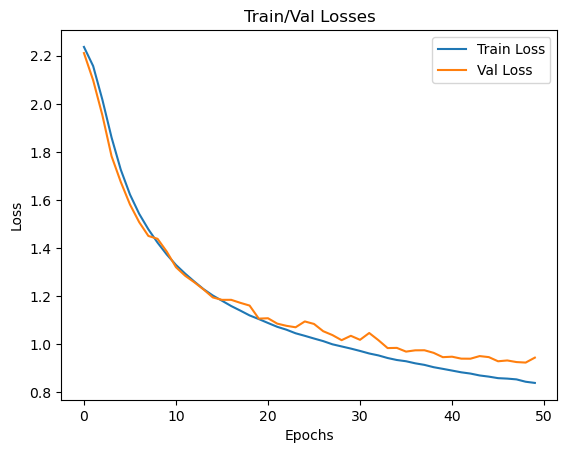

train_losses=[2.2366311415549247, 2.1570906234410137, 2.0175005474947563, 1.8599864130012818, 1.7260720701444716, 1.6227735378958297, 1.5423607572157811, 1.477798902127783, 1.422259776456748, 1.3729461455308531, 1.329578764107187, 1.293410580141753, 1.2601883441164015, 1.2287828646222567, 1.2025031204551413, 1.1806884939952562, 1.1585937509064301, 1.13945738474528, 1.119556216256959, 1.1044248376619614, 1.0880899553154288, 1.0722100753480206, 1.0602107468059718, 1.0452405800513591, 1.034669026846893, 1.023431609577847, 1.0126409903283127, 0.9994036415205573, 0.990493651359312, 0.9815870999557448, 0.9717617747237972, 0.9611854840945538, 0.9531463950689304, 0.9423178203873187, 0.9340503308035079, 0.9288951762123592, 0.9202775346335544, 0.9137545663136674, 0.9041417544727685, 0.8972381843216775, 0.8901057976960404, 0.8828338645226944, 0.8776471500046059, 0.8697534127535724, 0.8648620568410409, 0.8585603574774415, 0.8566625355506823, 0.8534409875556621, 0.843621518914967, 0.838702195708835

100%|██████████| 326/326 [00:00<00:00, 544.70it/s]

Epoch [1 out of 50], Train --> loss: 2.2311 & accuracy: 19.30%, Validation --> loss: 2.2081 & accuracy: 20.15%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 541.20it/s]

Epoch [2 out of 50], Train --> loss: 2.1605 & accuracy: 22.73%, Validation --> loss: 2.1057 & accuracy: 25.10%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 535.91it/s]

Epoch [3 out of 50], Train --> loss: 2.0333 & accuracy: 28.01%, Validation --> loss: 1.9664 & accuracy: 31.48%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 457.51it/s]

Epoch [4 out of 50], Train --> loss: 1.8987 & accuracy: 33.71%, Validation --> loss: 1.8467 & accuracy: 35.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 537.09it/s]

Epoch [5 out of 50], Train --> loss: 1.7732 & accuracy: 40.31%, Validation --> loss: 1.7121 & accuracy: 43.67%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 567.54it/s]

Epoch [6 out of 50], Train --> loss: 1.6604 & accuracy: 46.55%, Validation --> loss: 1.6138 & accuracy: 46.36%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 554.51it/s]

Epoch [7 out of 50], Train --> loss: 1.5698 & accuracy: 51.09%, Validation --> loss: 1.5389 & accuracy: 54.00%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 422.73it/s]

Epoch [8 out of 50], Train --> loss: 1.4951 & accuracy: 54.20%, Validation --> loss: 1.4841 & accuracy: 52.31%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 555.31it/s]

Epoch [9 out of 50], Train --> loss: 1.4337 & accuracy: 56.47%, Validation --> loss: 1.4132 & accuracy: 58.46%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 515.13it/s]

Epoch [10 out of 50], Train --> loss: 1.3807 & accuracy: 58.14%, Validation --> loss: 1.3772 & accuracy: 58.48%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 571.24it/s]

Epoch [11 out of 50], Train --> loss: 1.3374 & accuracy: 59.79%, Validation --> loss: 1.3288 & accuracy: 61.05%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 423.29it/s]

Epoch [12 out of 50], Train --> loss: 1.2965 & accuracy: 61.06%, Validation --> loss: 1.2925 & accuracy: 61.17%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 542.64it/s]

Epoch [13 out of 50], Train --> loss: 1.2658 & accuracy: 62.21%, Validation --> loss: 1.2742 & accuracy: 62.34%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 544.22it/s]

Epoch [14 out of 50], Train --> loss: 1.2340 & accuracy: 62.88%, Validation --> loss: 1.2405 & accuracy: 63.53%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 536.39it/s]

Epoch [15 out of 50], Train --> loss: 1.2105 & accuracy: 63.89%, Validation --> loss: 1.2198 & accuracy: 63.38%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 413.48it/s]

Epoch [16 out of 50], Train --> loss: 1.1863 & accuracy: 64.72%, Validation --> loss: 1.2140 & accuracy: 63.93%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 559.84it/s]

Epoch [17 out of 50], Train --> loss: 1.1648 & accuracy: 65.40%, Validation --> loss: 1.2149 & accuracy: 62.03%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 532.29it/s]

Epoch [18 out of 50], Train --> loss: 1.1476 & accuracy: 65.68%, Validation --> loss: 1.1557 & accuracy: 66.68%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 533.55it/s]

Epoch [19 out of 50], Train --> loss: 1.1294 & accuracy: 66.55%, Validation --> loss: 1.1405 & accuracy: 67.27%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 460.86it/s]

Epoch [20 out of 50], Train --> loss: 1.1140 & accuracy: 67.01%, Validation --> loss: 1.1447 & accuracy: 65.97%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 502.82it/s]

Epoch [21 out of 50], Train --> loss: 1.0989 & accuracy: 67.51%, Validation --> loss: 1.1298 & accuracy: 66.81%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 527.87it/s]

Epoch [22 out of 50], Train --> loss: 1.0865 & accuracy: 67.89%, Validation --> loss: 1.1285 & accuracy: 67.79%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 519.64it/s]

Epoch [23 out of 50], Train --> loss: 1.0711 & accuracy: 68.24%, Validation --> loss: 1.0998 & accuracy: 67.12%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 376.48it/s]

Epoch [24 out of 50], Train --> loss: 1.0624 & accuracy: 68.76%, Validation --> loss: 1.0885 & accuracy: 67.64%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 532.19it/s]

Epoch [25 out of 50], Train --> loss: 1.0481 & accuracy: 69.00%, Validation --> loss: 1.0814 & accuracy: 67.56%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 536.67it/s]

Epoch [26 out of 50], Train --> loss: 1.0402 & accuracy: 68.80%, Validation --> loss: 1.0744 & accuracy: 68.95%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 489.96it/s]

Epoch [27 out of 50], Train --> loss: 1.0294 & accuracy: 69.40%, Validation --> loss: 1.0917 & accuracy: 67.20%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 528.45it/s]

Epoch [28 out of 50], Train --> loss: 1.0221 & accuracy: 69.56%, Validation --> loss: 1.0602 & accuracy: 68.81%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 570.10it/s]

Epoch [29 out of 50], Train --> loss: 1.0115 & accuracy: 70.22%, Validation --> loss: 1.0544 & accuracy: 68.73%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 503.61it/s]

Epoch [30 out of 50], Train --> loss: 1.0049 & accuracy: 70.31%, Validation --> loss: 1.0403 & accuracy: 69.50%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 539.52it/s]

Epoch [31 out of 50], Train --> loss: 0.9943 & accuracy: 70.38%, Validation --> loss: 1.0498 & accuracy: 68.00%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 560.12it/s]

Epoch [32 out of 50], Train --> loss: 0.9862 & accuracy: 70.57%, Validation --> loss: 1.0243 & accuracy: 69.41%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 538.86it/s]

Epoch [33 out of 50], Train --> loss: 0.9786 & accuracy: 71.07%, Validation --> loss: 1.0220 & accuracy: 70.52%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 399.76it/s]

Epoch [34 out of 50], Train --> loss: 0.9727 & accuracy: 70.99%, Validation --> loss: 1.0095 & accuracy: 70.39%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 546.22it/s]

Epoch [35 out of 50], Train --> loss: 0.9669 & accuracy: 71.27%, Validation --> loss: 1.0149 & accuracy: 69.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 552.24it/s]

Epoch [36 out of 50], Train --> loss: 0.9598 & accuracy: 71.65%, Validation --> loss: 0.9958 & accuracy: 71.19%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 538.59it/s]

Epoch [37 out of 50], Train --> loss: 0.9511 & accuracy: 71.55%, Validation --> loss: 1.0026 & accuracy: 70.37%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 525.07it/s]

Epoch [38 out of 50], Train --> loss: 0.9451 & accuracy: 72.01%, Validation --> loss: 0.9941 & accuracy: 71.33%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 515.14it/s]

Epoch [39 out of 50], Train --> loss: 0.9399 & accuracy: 72.08%, Validation --> loss: 0.9848 & accuracy: 71.08%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 545.63it/s]

Epoch [40 out of 50], Train --> loss: 0.9362 & accuracy: 72.21%, Validation --> loss: 0.9847 & accuracy: 71.29%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 540.82it/s]

Epoch [41 out of 50], Train --> loss: 0.9281 & accuracy: 72.30%, Validation --> loss: 0.9815 & accuracy: 71.88%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 578.66it/s]

Epoch [42 out of 50], Train --> loss: 0.9219 & accuracy: 72.61%, Validation --> loss: 0.9791 & accuracy: 70.90%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 560.14it/s]

Epoch [43 out of 50], Train --> loss: 0.9155 & accuracy: 72.92%, Validation --> loss: 0.9758 & accuracy: 71.44%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 553.27it/s]

Epoch [44 out of 50], Train --> loss: 0.9109 & accuracy: 73.08%, Validation --> loss: 0.9753 & accuracy: 70.96%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 515.40it/s]

Epoch [45 out of 50], Train --> loss: 0.9066 & accuracy: 73.24%, Validation --> loss: 0.9580 & accuracy: 72.44%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 528.73it/s]

Epoch [46 out of 50], Train --> loss: 0.8992 & accuracy: 73.38%, Validation --> loss: 0.9743 & accuracy: 70.85%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 573.09it/s]

Epoch [47 out of 50], Train --> loss: 0.8945 & accuracy: 73.50%, Validation --> loss: 0.9458 & accuracy: 72.36%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 533.97it/s]

Epoch [48 out of 50], Train --> loss: 0.8920 & accuracy: 73.55%, Validation --> loss: 0.9471 & accuracy: 72.77%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 556.08it/s]

Epoch [49 out of 50], Train --> loss: 0.8855 & accuracy: 73.64%, Validation --> loss: 0.9593 & accuracy: 71.94%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 521.18it/s]

Epoch [50 out of 50], Train --> loss: 0.8797 & accuracy: 73.87%, Validation --> loss: 0.9455 & accuracy: 73.36%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 754.21it/s]


Test Accuracy: 74.07%


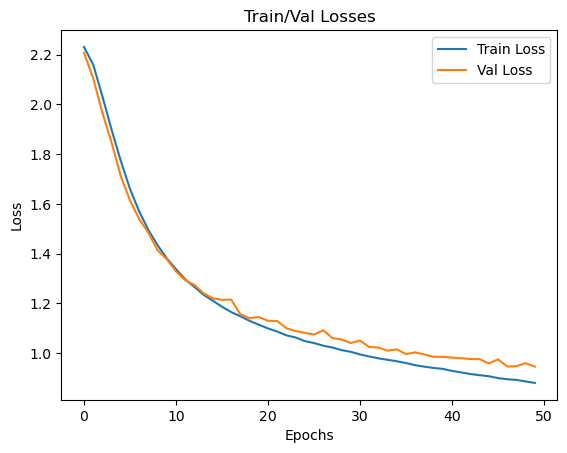

train_losses=[2.231138174160285, 2.160458643956485, 2.033334757783629, 1.8986511687346135, 1.7732357297624861, 1.6603965072587887, 1.5697649364830346, 1.4950767270705667, 1.4336986031766679, 1.3807499347377665, 1.337426065849269, 1.2965415194287278, 1.2657785006153601, 1.2340386458393615, 1.2105163675711452, 1.1862760440041575, 1.1647920067638113, 1.1476083512771331, 1.1294298780403929, 1.1140287401306281, 1.0988865696156995, 1.0865051518845301, 1.0711355920531966, 1.062405609086545, 1.048095570067473, 1.0401709898276263, 1.0294018239927365, 1.0220822008432515, 1.0115290639175247, 1.004887320433161, 0.9943113395695313, 0.9861808347811897, 0.9786363879931138, 0.9726947433159282, 0.9668544506147709, 0.9598217076649131, 0.951052673996502, 0.9450608021973098, 0.9399467510630458, 0.9361800613445437, 0.9280631220606249, 0.9219244278154798, 0.9154712366206306, 0.910911680652707, 0.9066384320137322, 0.8991541899454575, 0.8944873299947532, 0.8919679596219011, 0.8855345726196301, 0.8797369310703

In [33]:
best_results_without_bn = pd.DataFrame(columns=['optimizer', 'accuracy', 'learning_rate', 'weight_decay'])
num_epochs = 50

best_results_without_bn = train_grid_search(params=params, bn=False, num_epochs=num_epochs, results=best_results_without_bn)

In [34]:
best_results_without_bn

,optimizer,accuracy,learning_rate,weight_decay
0,RMSprop,0.763203,0.0001,0.0001
0,Adam,0.736316,0.0001,0.0010
0,Adam,0.733628,0.0001,0.0100


Можно заметить, что из всех этапов обучения, показаных выше, наилучший результат (76% точности) достигнут при помощи RMSprop оптимизатора.

Посмотрим, как будет вести себя данная нейросеть, если добавить слои с BatchNormalization.

# BatchNormalization

In [20]:
res_bn = pd.DataFrame(columns=['optimizer', 'accuracy', 'learning_rate', 'weight_decay'])
num_epochs = 10

weight_decay_list = [0.0001, 0.001, 0.01]
learning_rates = [0.0001, 0.001, 0.01]
optimizers = [Adam, optim.RMSprop]
params = [(x, y, z) for x in optimizers for y in learning_rates for z in weight_decay_list]

Params lr=0.0001, w=0.0001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 459.25it/s]

Epoch [1 out of 10], Train --> loss: 1.8567 & accuracy: 38.95%, Validation --> loss: 1.6838 & accuracy: 45.09%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 461.34it/s]

Epoch [2 out of 10], Train --> loss: 1.5502 & accuracy: 52.05%, Validation --> loss: 1.3883 & accuracy: 59.06%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 485.56it/s]

Epoch [3 out of 10], Train --> loss: 1.4413 & accuracy: 56.08%, Validation --> loss: 1.3993 & accuracy: 56.81%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 479.01it/s]

Epoch [4 out of 10], Train --> loss: 1.3717 & accuracy: 57.90%, Validation --> loss: 1.2457 & accuracy: 62.97%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 498.66it/s]

Epoch [5 out of 10], Train --> loss: 1.3017 & accuracy: 60.68%, Validation --> loss: 1.3753 & accuracy: 56.33%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 473.33it/s]

Epoch [6 out of 10], Train --> loss: 1.2597 & accuracy: 61.84%, Validation --> loss: 1.2043 & accuracy: 65.76%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 483.21it/s]

Epoch [7 out of 10], Train --> loss: 1.2060 & accuracy: 63.19%, Validation --> loss: 1.0442 & accuracy: 70.23%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 470.36it/s]

Epoch [8 out of 10], Train --> loss: 1.1758 & accuracy: 64.61%, Validation --> loss: 1.1246 & accuracy: 67.81%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 426.55it/s]

Epoch [9 out of 10], Train --> loss: 1.1530 & accuracy: 64.73%, Validation --> loss: 1.1560 & accuracy: 65.20%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 471.51it/s]

Epoch [10 out of 10], Train --> loss: 1.1207 & accuracy: 65.84%, Validation --> loss: 1.2010 & accuracy: 62.80%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 663.19it/s]


Test Accuracy: 64.93%


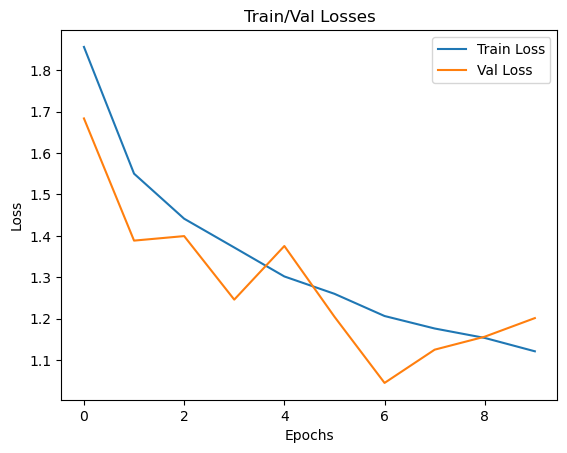

train_losses=[1.8567131697307533, 1.5502300839270315, 1.4413286889753034, 1.3717184414695118, 1.3016710207667401, 1.259721010969165, 1.2060038199256276, 1.1758331692621637, 1.1530232204728046, 1.1206888405408728]
[1.6838046224570713, 1.3883456436037287, 1.3992698360805862, 1.2456579549363787, 1.3753060261530379, 1.2043107625531273, 1.0442241040841203, 1.1246258109990805, 1.1560388286969414, 1.2009857027260071]
Params lr=0.0001, w=0.001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 465.82it/s]

Epoch [1 out of 10], Train --> loss: 1.8486 & accuracy: 39.01%, Validation --> loss: 1.6245 & accuracy: 49.51%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 472.92it/s]

Epoch [2 out of 10], Train --> loss: 1.5547 & accuracy: 51.21%, Validation --> loss: 1.5347 & accuracy: 49.47%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 474.10it/s]

Epoch [3 out of 10], Train --> loss: 1.4365 & accuracy: 56.01%, Validation --> loss: 1.2981 & accuracy: 61.30%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 478.94it/s]

Epoch [4 out of 10], Train --> loss: 1.3600 & accuracy: 58.59%, Validation --> loss: 1.4887 & accuracy: 52.03%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 455.20it/s]

Epoch [5 out of 10], Train --> loss: 1.2974 & accuracy: 60.79%, Validation --> loss: 1.2573 & accuracy: 63.72%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 460.81it/s]

Epoch [6 out of 10], Train --> loss: 1.2523 & accuracy: 62.29%, Validation --> loss: 1.2628 & accuracy: 63.01%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 432.43it/s]

Epoch [7 out of 10], Train --> loss: 1.2047 & accuracy: 63.78%, Validation --> loss: 1.1545 & accuracy: 63.55%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 465.96it/s]

Epoch [8 out of 10], Train --> loss: 1.1743 & accuracy: 64.47%, Validation --> loss: 1.0854 & accuracy: 71.54%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.88it/s]

Epoch [9 out of 10], Train --> loss: 1.1468 & accuracy: 65.09%, Validation --> loss: 1.0468 & accuracy: 70.04%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 467.91it/s]

Epoch [10 out of 10], Train --> loss: 1.1150 & accuracy: 66.36%, Validation --> loss: 1.0599 & accuracy: 68.08%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 677.23it/s]


Test Accuracy: 70.04%


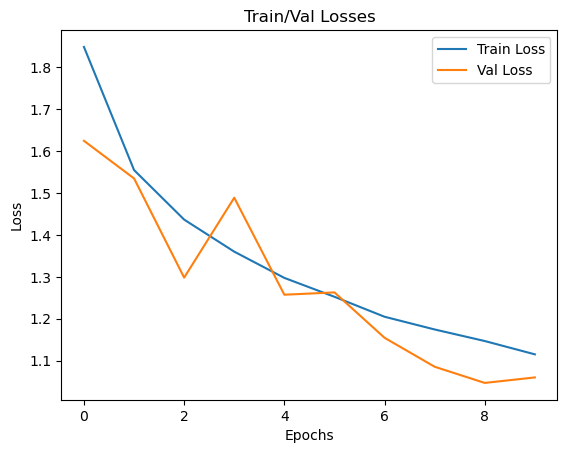

train_losses=[1.8485836522187322, 1.5547292322698643, 1.436519840483292, 1.3600209875864917, 1.2974073670335262, 1.2523336921419417, 1.2046938621869652, 1.1743379985132525, 1.1467561717223829, 1.1149968264106598]
[1.6245348499230812, 1.5347422034096865, 1.2980732786143485, 1.4887340505795976, 1.257266639566129, 1.2627731336772077, 1.1544932624313728, 1.085389881229108, 1.0467908642043364, 1.0598991268251572]
Params lr=0.0001, w=0.01, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 472.63it/s]

Epoch [1 out of 10], Train --> loss: 1.8487 & accuracy: 38.82%, Validation --> loss: 1.7423 & accuracy: 48.01%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 490.13it/s]

Epoch [2 out of 10], Train --> loss: 1.5472 & accuracy: 51.90%, Validation --> loss: 1.5712 & accuracy: 51.30%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 472.39it/s]

Epoch [3 out of 10], Train --> loss: 1.4404 & accuracy: 55.54%, Validation --> loss: 1.2646 & accuracy: 66.37%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 459.74it/s]

Epoch [4 out of 10], Train --> loss: 1.3663 & accuracy: 58.35%, Validation --> loss: 1.2985 & accuracy: 59.59%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.69it/s]

Epoch [5 out of 10], Train --> loss: 1.3004 & accuracy: 60.80%, Validation --> loss: 1.4021 & accuracy: 52.83%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 462.84it/s]

Epoch [6 out of 10], Train --> loss: 1.2542 & accuracy: 62.27%, Validation --> loss: 1.1103 & accuracy: 69.56%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 415.08it/s]

Epoch [7 out of 10], Train --> loss: 1.2043 & accuracy: 63.70%, Validation --> loss: 1.2697 & accuracy: 59.04%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 476.87it/s]

Epoch [8 out of 10], Train --> loss: 1.1840 & accuracy: 64.27%, Validation --> loss: 1.1532 & accuracy: 66.58%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.46it/s]

Epoch [9 out of 10], Train --> loss: 1.1474 & accuracy: 65.07%, Validation --> loss: 1.1174 & accuracy: 68.83%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 463.62it/s]

Epoch [10 out of 10], Train --> loss: 1.1208 & accuracy: 66.22%, Validation --> loss: 1.0445 & accuracy: 69.41%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 665.88it/s]


Test Accuracy: 71.20%


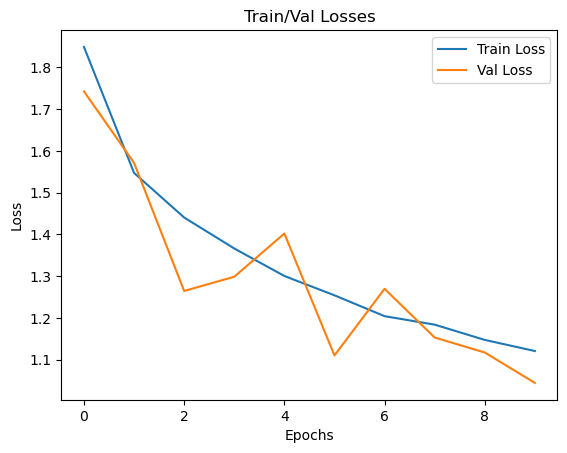

train_losses=[1.8487053369779924, 1.547165680041511, 1.4404042928083334, 1.3663008840677375, 1.3004222877106175, 1.2541671667688636, 1.2042838240274087, 1.1839704297929317, 1.1474362053263205, 1.1208235404458464]
[1.7422682959243563, 1.5712410931938265, 1.2646463197067472, 1.2985468399853795, 1.4020713322733078, 1.1102560637918717, 1.2697396603830022, 1.1531609243776169, 1.1173551237107786, 1.0444753257774868]
Params lr=0.001, w=0.0001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 502.54it/s]

Epoch [1 out of 10], Train --> loss: 1.8528 & accuracy: 37.55%, Validation --> loss: 1.7310 & accuracy: 43.52%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 479.61it/s]

Epoch [2 out of 10], Train --> loss: 1.5147 & accuracy: 50.75%, Validation --> loss: 1.4611 & accuracy: 52.97%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 474.71it/s]

Epoch [3 out of 10], Train --> loss: 1.3694 & accuracy: 56.64%, Validation --> loss: 1.8597 & accuracy: 41.85%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.36it/s]

Epoch [4 out of 10], Train --> loss: 1.2828 & accuracy: 59.42%, Validation --> loss: 1.2361 & accuracy: 60.82%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 459.14it/s]

Epoch [5 out of 10], Train --> loss: 1.2042 & accuracy: 61.77%, Validation --> loss: 1.2237 & accuracy: 62.32%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 453.76it/s]

Epoch [6 out of 10], Train --> loss: 1.1630 & accuracy: 62.91%, Validation --> loss: 0.9964 & accuracy: 71.48%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 472.46it/s]

Epoch [7 out of 10], Train --> loss: 1.1148 & accuracy: 64.59%, Validation --> loss: 1.0179 & accuracy: 70.48%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 471.05it/s]

Epoch [8 out of 10], Train --> loss: 1.0617 & accuracy: 66.32%, Validation --> loss: 0.9156 & accuracy: 73.92%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 452.72it/s]

Epoch [9 out of 10], Train --> loss: 1.0266 & accuracy: 67.35%, Validation --> loss: 1.0261 & accuracy: 67.79%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.15it/s]

Epoch [10 out of 10], Train --> loss: 1.0181 & accuracy: 67.82%, Validation --> loss: 0.9663 & accuracy: 71.83%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 669.57it/s]


Test Accuracy: 73.66%


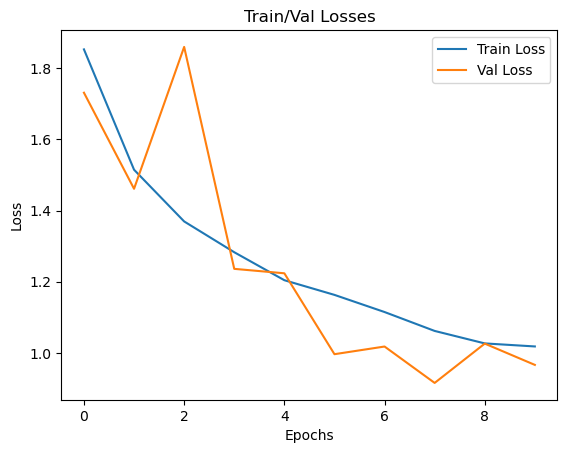

train_losses=[1.8528045352702867, 1.5146615060701532, 1.3693594337883084, 1.2828411112000133, 1.2042336589592393, 1.163000288280657, 1.1148166317956238, 1.0617060781257677, 1.0266497728004251, 1.0181049727899139]
[1.731007331902264, 1.4611230004418847, 1.8596947588072232, 1.236142343355834, 1.2236568933249983, 0.9963621678162207, 1.0178977819673853, 0.9156345813735131, 1.0260910210799585, 0.9662804914398427]
Params lr=0.001, w=0.001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 492.99it/s]

Epoch [1 out of 10], Train --> loss: 1.8794 & accuracy: 36.45%, Validation --> loss: 1.9838 & accuracy: 35.05%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 496.50it/s]

Epoch [2 out of 10], Train --> loss: 1.5060 & accuracy: 51.20%, Validation --> loss: 1.4914 & accuracy: 50.18%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 475.46it/s]

Epoch [3 out of 10], Train --> loss: 1.3675 & accuracy: 56.20%, Validation --> loss: 1.7972 & accuracy: 50.47%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 461.56it/s]

Epoch [4 out of 10], Train --> loss: 1.2828 & accuracy: 58.93%, Validation --> loss: 1.3734 & accuracy: 55.68%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 449.34it/s]

Epoch [5 out of 10], Train --> loss: 1.2182 & accuracy: 60.74%, Validation --> loss: 1.1627 & accuracy: 64.55%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 466.29it/s]

Epoch [6 out of 10], Train --> loss: 1.1559 & accuracy: 63.54%, Validation --> loss: 1.1895 & accuracy: 63.40%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 468.96it/s]

Epoch [7 out of 10], Train --> loss: 1.1139 & accuracy: 64.70%, Validation --> loss: 1.0395 & accuracy: 69.16%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 460.82it/s]

Epoch [8 out of 10], Train --> loss: 1.0838 & accuracy: 65.79%, Validation --> loss: 0.9541 & accuracy: 72.34%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 456.14it/s]

Epoch [9 out of 10], Train --> loss: 1.0494 & accuracy: 66.61%, Validation --> loss: 0.9747 & accuracy: 71.81%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 453.31it/s]

Epoch [10 out of 10], Train --> loss: 1.0311 & accuracy: 67.28%, Validation --> loss: 1.0424 & accuracy: 68.24%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 659.69it/s]


Test Accuracy: 70.66%


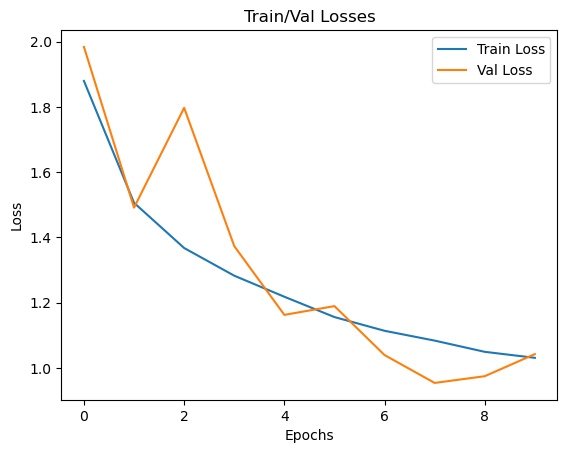

train_losses=[1.8794266878185184, 1.5060210162501915, 1.3675354769977006, 1.2827582632616368, 1.2182341100341896, 1.15594449925441, 1.1138965524332498, 1.083821036940163, 1.0494221185438461, 1.0310614173130324]
[1.9837837694612748, 1.4914109538669236, 1.7971865492730053, 1.373408734615595, 1.1626702656775165, 1.1895424844297164, 1.0395126627998117, 0.954149138068129, 0.9747320082198623, 1.042419018281018]
Params lr=0.001, w=0.01, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 452.58it/s]

Epoch [1 out of 10], Train --> loss: 1.8603 & accuracy: 37.86%, Validation --> loss: 1.5744 & accuracy: 51.01%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 460.42it/s]

Epoch [2 out of 10], Train --> loss: 1.5122 & accuracy: 50.67%, Validation --> loss: 1.4809 & accuracy: 50.14%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 480.41it/s]

Epoch [3 out of 10], Train --> loss: 1.3648 & accuracy: 56.25%, Validation --> loss: 1.2446 & accuracy: 60.92%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 360.28it/s]

Epoch [4 out of 10], Train --> loss: 1.2769 & accuracy: 59.55%, Validation --> loss: 1.1844 & accuracy: 63.30%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 464.27it/s]

Epoch [5 out of 10], Train --> loss: 1.1979 & accuracy: 62.07%, Validation --> loss: 1.2119 & accuracy: 60.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 457.91it/s]

Epoch [6 out of 10], Train --> loss: 1.1508 & accuracy: 63.52%, Validation --> loss: 1.0091 & accuracy: 70.06%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 480.48it/s]

Epoch [7 out of 10], Train --> loss: 1.1104 & accuracy: 64.84%, Validation --> loss: 1.0648 & accuracy: 68.58%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 343.98it/s]


Epoch [8 out of 10], Train --> loss: 1.0666 & accuracy: 66.51%, Validation --> loss: 0.9717 & accuracy: 71.65%
Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 474.94it/s]

Epoch [9 out of 10], Train --> loss: 1.0437 & accuracy: 66.84%, Validation --> loss: 1.0520 & accuracy: 66.51%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 491.60it/s]

Epoch [10 out of 10], Train --> loss: 1.0196 & accuracy: 67.84%, Validation --> loss: 1.0742 & accuracy: 67.52%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 667.74it/s]


Test Accuracy: 69.43%


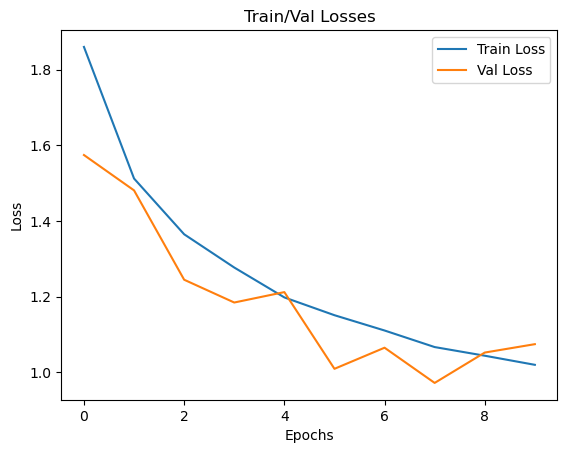

train_losses=[1.8602572929474614, 1.5122127281630644, 1.3648304671918925, 1.2769016506759803, 1.1978653748555483, 1.1508135420660819, 1.110368545383169, 1.066567886260248, 1.0436837889723332, 1.0196063580555117]
[1.5744106665345057, 1.4808828748442644, 1.2446320508521027, 1.1843568776831306, 1.211899448940359, 1.0090522948949614, 1.0648467132101762, 0.9717444120192089, 1.052034174829173, 1.0742337906653165]
Params lr=0.01, w=0.0001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 478.55it/s]

Epoch [1 out of 10], Train --> loss: 1.8798 & accuracy: 34.82%, Validation --> loss: 1.6342 & accuracy: 45.17%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 462.35it/s]

Epoch [2 out of 10], Train --> loss: 1.5004 & accuracy: 50.60%, Validation --> loss: 1.5243 & accuracy: 52.43%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 487.52it/s]

Epoch [3 out of 10], Train --> loss: 1.3667 & accuracy: 55.60%, Validation --> loss: 1.3632 & accuracy: 56.14%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 476.71it/s]

Epoch [4 out of 10], Train --> loss: 1.2876 & accuracy: 58.68%, Validation --> loss: 1.1913 & accuracy: 63.22%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 477.50it/s]

Epoch [5 out of 10], Train --> loss: 1.2261 & accuracy: 60.64%, Validation --> loss: 1.1532 & accuracy: 64.86%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 482.90it/s]

Epoch [6 out of 10], Train --> loss: 1.1818 & accuracy: 62.26%, Validation --> loss: 1.0817 & accuracy: 66.64%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 504.95it/s]

Epoch [7 out of 10], Train --> loss: 1.1504 & accuracy: 63.38%, Validation --> loss: 1.0083 & accuracy: 69.48%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 475.40it/s]

Epoch [8 out of 10], Train --> loss: 1.1002 & accuracy: 65.24%, Validation --> loss: 1.0639 & accuracy: 67.54%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 480.05it/s]

Epoch [9 out of 10], Train --> loss: 1.0828 & accuracy: 65.80%, Validation --> loss: 1.1014 & accuracy: 66.64%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 460.72it/s]

Epoch [10 out of 10], Train --> loss: 1.0595 & accuracy: 66.50%, Validation --> loss: 1.0064 & accuracy: 70.02%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 659.90it/s]


Test Accuracy: 72.40%


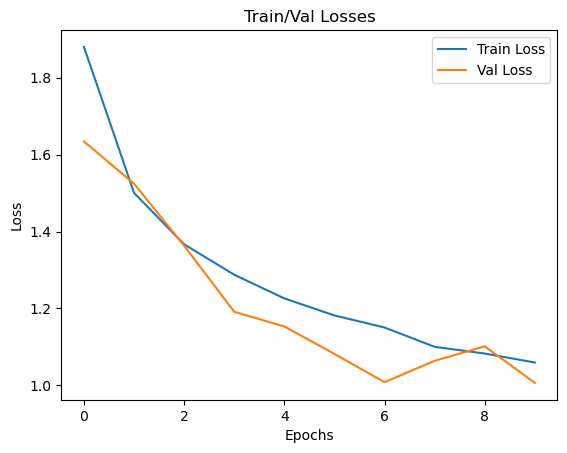

train_losses=[1.8798177304081103, 1.5004198649145675, 1.3667308236322095, 1.2876101247909066, 1.2261029141289848, 1.1818099181681367, 1.1504487129308845, 1.1001904833426672, 1.0827745988896365, 1.059478936061698]
[1.6342026448688625, 1.524255280480063, 1.363212375187435, 1.1913125461961593, 1.1531738955184725, 1.0817235035398987, 1.00831320909269, 1.0639320239881795, 1.1014429146161109, 1.0064225508574327]
Params lr=0.01, w=0.001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 470.57it/s]

Epoch [1 out of 10], Train --> loss: 1.8740 & accuracy: 35.51%, Validation --> loss: 1.5116 & accuracy: 50.93%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 478.89it/s]

Epoch [2 out of 10], Train --> loss: 1.4879 & accuracy: 51.12%, Validation --> loss: 1.4317 & accuracy: 54.64%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 485.18it/s]

Epoch [3 out of 10], Train --> loss: 1.3849 & accuracy: 55.12%, Validation --> loss: 1.3842 & accuracy: 52.87%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 494.88it/s]

Epoch [4 out of 10], Train --> loss: 1.3101 & accuracy: 58.09%, Validation --> loss: 1.1596 & accuracy: 64.64%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 477.20it/s]

Epoch [5 out of 10], Train --> loss: 1.2603 & accuracy: 60.00%, Validation --> loss: 1.1010 & accuracy: 66.39%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.01it/s]

Epoch [6 out of 10], Train --> loss: 1.2141 & accuracy: 61.17%, Validation --> loss: 1.1747 & accuracy: 63.43%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 486.36it/s]

Epoch [7 out of 10], Train --> loss: 1.1681 & accuracy: 62.73%, Validation --> loss: 1.0268 & accuracy: 67.95%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 474.72it/s]

Epoch [8 out of 10], Train --> loss: 1.1394 & accuracy: 63.97%, Validation --> loss: 1.0714 & accuracy: 66.43%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 484.06it/s]

Epoch [9 out of 10], Train --> loss: 1.1118 & accuracy: 64.73%, Validation --> loss: 0.9800 & accuracy: 70.50%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 461.03it/s]

Epoch [10 out of 10], Train --> loss: 1.0993 & accuracy: 65.14%, Validation --> loss: 1.0661 & accuracy: 67.06%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 667.82it/s]


Test Accuracy: 69.36%


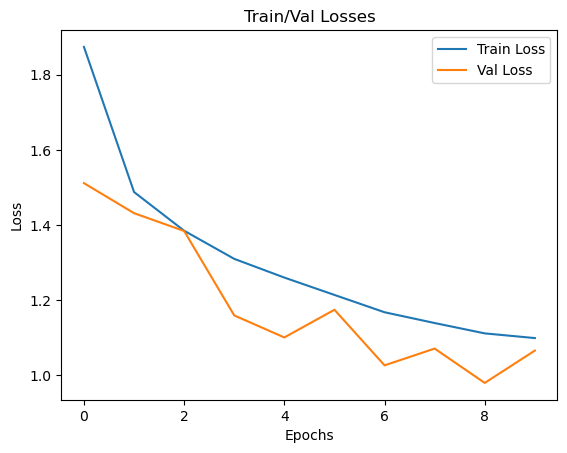

train_losses=[1.8740267256437908, 1.4879128558020438, 1.3849453596017693, 1.3101117034112253, 1.2603087517248321, 1.2141494470807264, 1.1680519720925713, 1.1393793411152338, 1.111838835679258, 1.0993490957994065]
[1.5115595432512599, 1.4317171692482533, 1.3842385806188993, 1.1595961904050383, 1.1010365100360355, 1.1746896121399535, 1.0267725169110151, 1.0714055812614827, 0.9800288688185756, 1.0661174399903948]
Params lr=0.01, w=0.01, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 471.57it/s]

Epoch [1 out of 10], Train --> loss: 1.9289 & accuracy: 32.67%, Validation --> loss: 2.0295 & accuracy: 32.26%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 490.45it/s]

Epoch [2 out of 10], Train --> loss: 1.5243 & accuracy: 49.52%, Validation --> loss: 1.6094 & accuracy: 49.91%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 468.03it/s]

Epoch [3 out of 10], Train --> loss: 1.4162 & accuracy: 53.61%, Validation --> loss: 1.3035 & accuracy: 58.44%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 481.47it/s]

Epoch [4 out of 10], Train --> loss: 1.3515 & accuracy: 56.52%, Validation --> loss: 1.9289 & accuracy: 41.71%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 482.08it/s]

Epoch [5 out of 10], Train --> loss: 1.3228 & accuracy: 57.49%, Validation --> loss: 1.2297 & accuracy: 60.42%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 478.37it/s]

Epoch [6 out of 10], Train --> loss: 1.2745 & accuracy: 59.25%, Validation --> loss: 1.3044 & accuracy: 61.05%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 467.27it/s]

Epoch [7 out of 10], Train --> loss: 1.2371 & accuracy: 60.46%, Validation --> loss: 1.4156 & accuracy: 55.18%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 476.62it/s]

Epoch [8 out of 10], Train --> loss: 1.2302 & accuracy: 61.11%, Validation --> loss: 1.1936 & accuracy: 62.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 478.86it/s]

Epoch [9 out of 10], Train --> loss: 1.2282 & accuracy: 60.57%, Validation --> loss: 1.4895 & accuracy: 53.29%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 468.97it/s]

Epoch [10 out of 10], Train --> loss: 1.2102 & accuracy: 61.30%, Validation --> loss: 1.2269 & accuracy: 61.96%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 604.36it/s]


Test Accuracy: 62.19%


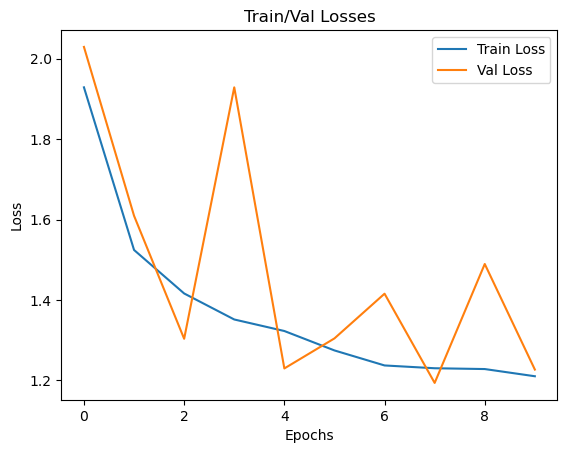

train_losses=[1.928947343529644, 1.5243499920390169, 1.4161732919662962, 1.3514587658066903, 1.3227764515008795, 1.274460550597919, 1.2371090002323626, 1.2301507170802803, 1.2281522669367344, 1.2102427830985432]
[2.0294596077474347, 1.6094058170640395, 1.3034548982520777, 1.9289239491421752, 1.2296740502301902, 1.3044025517680162, 1.4155949699732424, 1.193647190288532, 1.4894673268487848, 1.2268732328173573]
Params lr=0.0001, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 457.91it/s]

Epoch [1 out of 10], Train --> loss: 1.8181 & accuracy: 40.61%, Validation --> loss: 1.8179 & accuracy: 39.49%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 465.67it/s]

Epoch [2 out of 10], Train --> loss: 1.5231 & accuracy: 52.87%, Validation --> loss: 1.7388 & accuracy: 43.25%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 466.00it/s]

Epoch [3 out of 10], Train --> loss: 1.4275 & accuracy: 56.21%, Validation --> loss: 2.3352 & accuracy: 30.38%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 466.74it/s]

Epoch [4 out of 10], Train --> loss: 1.3462 & accuracy: 59.25%, Validation --> loss: 1.3553 & accuracy: 56.04%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 456.25it/s]

Epoch [5 out of 10], Train --> loss: 1.2854 & accuracy: 61.25%, Validation --> loss: 1.4879 & accuracy: 54.43%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 449.56it/s]

Epoch [6 out of 10], Train --> loss: 1.2367 & accuracy: 62.80%, Validation --> loss: 1.2521 & accuracy: 59.73%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 463.69it/s]

Epoch [7 out of 10], Train --> loss: 1.2006 & accuracy: 63.63%, Validation --> loss: 1.3721 & accuracy: 57.77%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 447.03it/s]

Epoch [8 out of 10], Train --> loss: 1.1541 & accuracy: 65.37%, Validation --> loss: 1.2339 & accuracy: 64.11%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 384.70it/s]

Epoch [9 out of 10], Train --> loss: 1.1283 & accuracy: 65.69%, Validation --> loss: 1.4516 & accuracy: 55.19%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 497.03it/s]

Epoch [10 out of 10], Train --> loss: 1.0915 & accuracy: 67.30%, Validation --> loss: 1.5348 & accuracy: 50.39%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 673.80it/s]


Test Accuracy: 52.57%


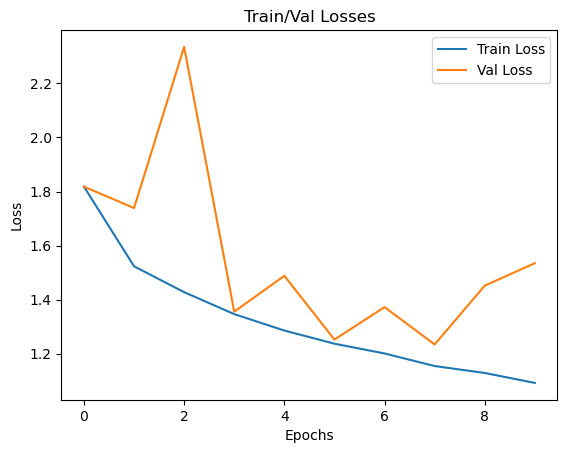

train_losses=[1.8181184592518023, 1.5231403982675935, 1.4274579779160554, 1.3461884731246578, 1.2853702804826188, 1.2367311293994594, 1.2005833923450446, 1.1540715011858171, 1.1283180817114775, 1.0915414019846879]
[1.8179307488576035, 1.7388050490361782, 2.335181347797253, 1.3552648068571382, 1.4879179691975832, 1.2520588029381687, 1.3720621843279506, 1.2339189672396957, 1.451573214099451, 1.534810183238398]
Params lr=0.0001, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 460.96it/s]

Epoch [1 out of 10], Train --> loss: 1.8149 & accuracy: 40.39%, Validation --> loss: 1.7577 & accuracy: 43.00%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 462.83it/s]

Epoch [2 out of 10], Train --> loss: 1.5452 & accuracy: 51.92%, Validation --> loss: 1.7696 & accuracy: 40.16%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 464.28it/s]

Epoch [3 out of 10], Train --> loss: 1.4163 & accuracy: 56.95%, Validation --> loss: 1.4387 & accuracy: 55.02%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 485.55it/s]

Epoch [4 out of 10], Train --> loss: 1.3439 & accuracy: 59.72%, Validation --> loss: 1.3869 & accuracy: 57.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 495.91it/s]

Epoch [5 out of 10], Train --> loss: 1.2800 & accuracy: 61.77%, Validation --> loss: 1.2429 & accuracy: 62.55%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 500.31it/s]

Epoch [6 out of 10], Train --> loss: 1.2330 & accuracy: 63.13%, Validation --> loss: 1.1504 & accuracy: 68.00%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 466.04it/s]

Epoch [7 out of 10], Train --> loss: 1.1968 & accuracy: 63.85%, Validation --> loss: 1.4928 & accuracy: 53.54%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 394.44it/s]

Epoch [8 out of 10], Train --> loss: 1.1499 & accuracy: 65.58%, Validation --> loss: 1.0858 & accuracy: 69.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 480.72it/s]

Epoch [9 out of 10], Train --> loss: 1.1356 & accuracy: 65.76%, Validation --> loss: 1.0195 & accuracy: 73.73%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 474.20it/s]

Epoch [10 out of 10], Train --> loss: 1.1050 & accuracy: 66.41%, Validation --> loss: 1.5306 & accuracy: 51.72%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 664.53it/s]


Test Accuracy: 54.46%


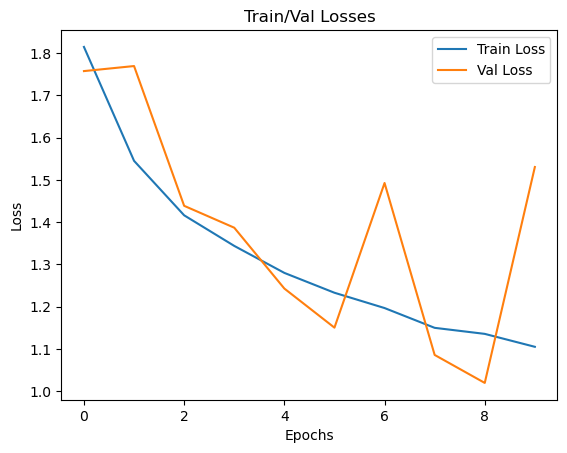

train_losses=[1.8148548813642629, 1.5452239261611083, 1.4162859972079962, 1.3438636812563134, 1.2799765290935652, 1.2329807877540588, 1.196759945282372, 1.1499166104559158, 1.135626748227121, 1.1050163335789185]
[1.7576510679502428, 1.7695787457600693, 1.4387457857102703, 1.3869409043730403, 1.24291546359384, 1.1503766312555301, 1.4927692548628966, 1.0857654360174402, 1.0195287615060806, 1.53059079328929]
Params lr=0.0001, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 479.57it/s]

Epoch [1 out of 10], Train --> loss: 1.8299 & accuracy: 39.76%, Validation --> loss: 1.8841 & accuracy: 36.16%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 477.28it/s]

Epoch [2 out of 10], Train --> loss: 1.5564 & accuracy: 51.31%, Validation --> loss: 1.6720 & accuracy: 44.90%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 478.45it/s]

Epoch [3 out of 10], Train --> loss: 1.4600 & accuracy: 55.56%, Validation --> loss: 3.4508 & accuracy: 21.16%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 475.53it/s]

Epoch [4 out of 10], Train --> loss: 1.3976 & accuracy: 57.39%, Validation --> loss: 1.3560 & accuracy: 60.44%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 465.16it/s]

Epoch [5 out of 10], Train --> loss: 1.3478 & accuracy: 58.97%, Validation --> loss: 1.3328 & accuracy: 63.20%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 477.76it/s]

Epoch [6 out of 10], Train --> loss: 1.3048 & accuracy: 60.95%, Validation --> loss: 1.3016 & accuracy: 61.23%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 462.94it/s]

Epoch [7 out of 10], Train --> loss: 1.2653 & accuracy: 62.11%, Validation --> loss: 1.3032 & accuracy: 58.25%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 458.72it/s]

Epoch [8 out of 10], Train --> loss: 1.2455 & accuracy: 62.66%, Validation --> loss: 1.6837 & accuracy: 42.58%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 410.71it/s]

Epoch [9 out of 10], Train --> loss: 1.2161 & accuracy: 63.66%, Validation --> loss: 1.2281 & accuracy: 63.11%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 463.85it/s]

Epoch [10 out of 10], Train --> loss: 1.2040 & accuracy: 63.58%, Validation --> loss: 1.5121 & accuracy: 48.13%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 681.53it/s]


Test Accuracy: 49.07%


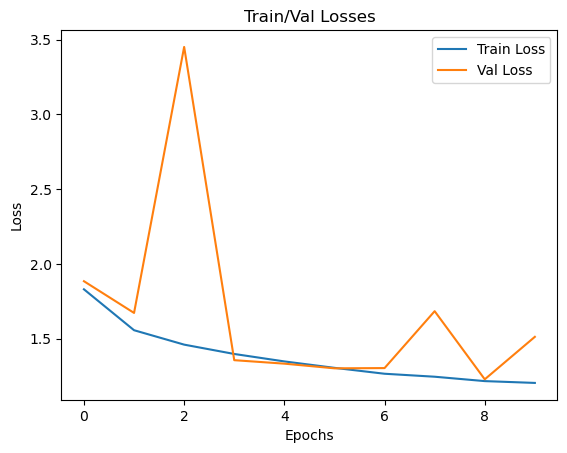

train_losses=[1.8299080129775767, 1.556391307926764, 1.4600307089026257, 1.397581084853127, 1.3477649964769864, 1.3047944887808758, 1.2653361122637483, 1.2454536104898115, 1.2161184678429282, 1.2039860767611343]
[1.8840670647796678, 1.6720186801044488, 3.4507604329132593, 1.356045831566208, 1.332831984465839, 1.3016027201172764, 1.3032077689843675, 1.6837274613190283, 1.2280915728741628, 1.5121346501850643]
Params lr=0.001, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 472.13it/s]

Epoch [1 out of 10], Train --> loss: 1.8372 & accuracy: 38.70%, Validation --> loss: 1.8341 & accuracy: 40.08%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 490.91it/s]

Epoch [2 out of 10], Train --> loss: 1.4942 & accuracy: 51.69%, Validation --> loss: 1.8545 & accuracy: 40.81%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 461.27it/s]

Epoch [3 out of 10], Train --> loss: 1.3677 & accuracy: 56.18%, Validation --> loss: 1.8528 & accuracy: 36.41%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 510.74it/s]

Epoch [4 out of 10], Train --> loss: 1.2846 & accuracy: 58.90%, Validation --> loss: 1.6086 & accuracy: 49.61%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 466.06it/s]

Epoch [5 out of 10], Train --> loss: 1.2109 & accuracy: 61.50%, Validation --> loss: 2.3386 & accuracy: 38.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 471.10it/s]

Epoch [6 out of 10], Train --> loss: 1.1646 & accuracy: 62.53%, Validation --> loss: 1.1767 & accuracy: 61.71%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 365.65it/s]

Epoch [7 out of 10], Train --> loss: 1.1312 & accuracy: 63.90%, Validation --> loss: 1.0608 & accuracy: 67.22%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 472.05it/s]

Epoch [8 out of 10], Train --> loss: 1.1023 & accuracy: 64.78%, Validation --> loss: 1.1071 & accuracy: 66.37%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 491.13it/s]

Epoch [9 out of 10], Train --> loss: 1.0725 & accuracy: 65.68%, Validation --> loss: 3.3880 & accuracy: 29.65%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 488.25it/s]

Epoch [10 out of 10], Train --> loss: 1.0578 & accuracy: 66.29%, Validation --> loss: 1.2315 & accuracy: 64.55%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 657.69it/s]


Test Accuracy: 65.55%


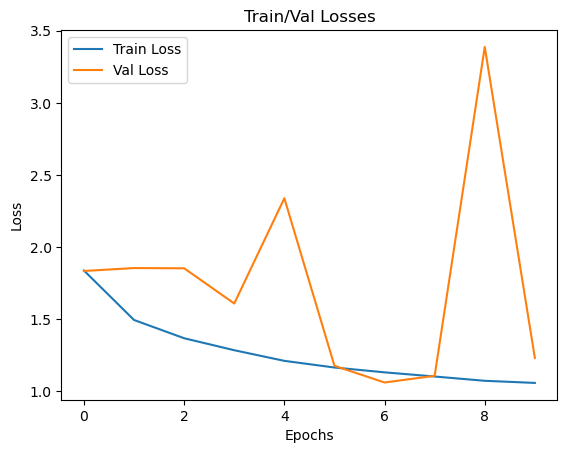

train_losses=[1.8371748533757968, 1.494196935091883, 1.3677457883244468, 1.28460424520453, 1.2108780104901566, 1.1646474678578649, 1.1311646502138832, 1.1022744678681897, 1.072547685326336, 1.0578109116598209]
[1.8340818498032225, 1.8544792847399332, 1.8527967679354311, 1.608593651853456, 2.3386155728913525, 1.1766539160276483, 1.0608112117264168, 1.1070650863501192, 3.388005507504282, 1.2314904976659027]
Params lr=0.001, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 469.88it/s]

Epoch [1 out of 10], Train --> loss: 1.8483 & accuracy: 37.66%, Validation --> loss: 2.7325 & accuracy: 29.56%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 479.33it/s]

Epoch [2 out of 10], Train --> loss: 1.5813 & accuracy: 48.05%, Validation --> loss: 2.0852 & accuracy: 32.19%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 471.37it/s]

Epoch [3 out of 10], Train --> loss: 1.4779 & accuracy: 51.94%, Validation --> loss: 2.1847 & accuracy: 36.93%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 468.08it/s]

Epoch [4 out of 10], Train --> loss: 1.4146 & accuracy: 54.09%, Validation --> loss: 1.6822 & accuracy: 49.38%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.03it/s]

Epoch [5 out of 10], Train --> loss: 1.3604 & accuracy: 56.23%, Validation --> loss: 3.3991 & accuracy: 21.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 478.47it/s]

Epoch [6 out of 10], Train --> loss: 1.3267 & accuracy: 57.71%, Validation --> loss: 1.5579 & accuracy: 51.26%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 440.11it/s]

Epoch [7 out of 10], Train --> loss: 1.3043 & accuracy: 58.35%, Validation --> loss: 2.8193 & accuracy: 36.85%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 474.99it/s]

Epoch [8 out of 10], Train --> loss: 1.2936 & accuracy: 58.18%, Validation --> loss: 1.5301 & accuracy: 55.89%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 488.52it/s]

Epoch [9 out of 10], Train --> loss: 1.2868 & accuracy: 58.58%, Validation --> loss: 2.1813 & accuracy: 40.56%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 481.23it/s]

Epoch [10 out of 10], Train --> loss: 1.2806 & accuracy: 58.72%, Validation --> loss: 2.8011 & accuracy: 31.42%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 663.18it/s]


Test Accuracy: 31.70%


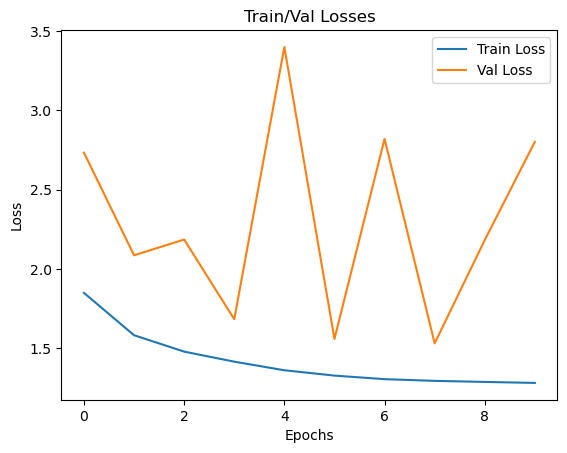

train_losses=[1.8483408865291402, 1.5813223334135182, 1.4779377295857383, 1.4146292092888038, 1.3603761562828645, 1.3267492259153024, 1.3042504770506729, 1.2936207866339091, 1.2868360996063222, 1.2805718537849216]
[2.732485134543085, 2.085195496038425, 2.1847169761277416, 1.6821589079554096, 3.3991246545241656, 1.5578630796970765, 2.8192654859068935, 1.5300823239826717, 2.181335007486168, 2.8010765299475264]
Params lr=0.001, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 490.63it/s]

Epoch [1 out of 10], Train --> loss: 2.0694 & accuracy: 27.96%, Validation --> loss: 2.9360 & accuracy: 17.92%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 466.13it/s]

Epoch [2 out of 10], Train --> loss: 1.8122 & accuracy: 37.80%, Validation --> loss: 2.0107 & accuracy: 32.84%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 480.69it/s]

Epoch [3 out of 10], Train --> loss: 1.7376 & accuracy: 40.96%, Validation --> loss: 2.3434 & accuracy: 22.97%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 482.64it/s]

Epoch [4 out of 10], Train --> loss: 1.7166 & accuracy: 41.37%, Validation --> loss: 2.4351 & accuracy: 28.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 471.93it/s]

Epoch [5 out of 10], Train --> loss: 1.7064 & accuracy: 42.44%, Validation --> loss: 2.7255 & accuracy: 22.87%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 383.07it/s]

Epoch [6 out of 10], Train --> loss: 1.6930 & accuracy: 42.78%, Validation --> loss: 2.6595 & accuracy: 27.25%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 486.70it/s]

Epoch [7 out of 10], Train --> loss: 1.6871 & accuracy: 43.06%, Validation --> loss: 2.3300 & accuracy: 25.27%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 462.19it/s]

Epoch [8 out of 10], Train --> loss: 1.6931 & accuracy: 42.77%, Validation --> loss: 1.9427 & accuracy: 34.91%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 472.60it/s]

Epoch [9 out of 10], Train --> loss: 1.6764 & accuracy: 43.32%, Validation --> loss: 2.1251 & accuracy: 24.62%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 347.32it/s]

Epoch [10 out of 10], Train --> loss: 1.6876 & accuracy: 42.79%, Validation --> loss: 2.8392 & accuracy: 24.45%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 686.15it/s]


Test Accuracy: 24.17%


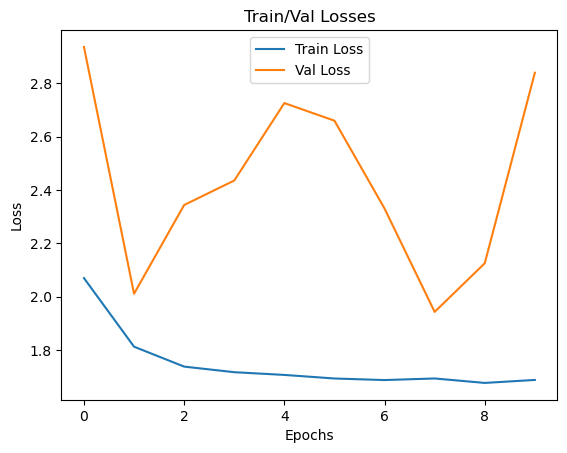

train_losses=[2.0694491094158542, 1.8122255190543133, 1.7375697935781171, 1.7166330282406141, 1.7063935493360833, 1.6930111429658354, 1.6871271895190354, 1.6931075143374605, 1.676411588895156, 1.6876123528326712]
[2.9360107713681787, 2.010736456312285, 2.3433843383028465, 2.4351091538470215, 2.7255142726049835, 2.6594764608547, 2.3300154348092574, 1.942689528494525, 2.125088632472454, 2.8392155331336646]
Params lr=0.01, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 485.38it/s]

Epoch [1 out of 10], Train --> loss: 2.0019 & accuracy: 29.57%, Validation --> loss: 2.5937 & accuracy: 25.97%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 467.43it/s]

Epoch [2 out of 10], Train --> loss: 1.7136 & accuracy: 41.47%, Validation --> loss: 1.5875 & accuracy: 46.13%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 485.59it/s]


Epoch [3 out of 10], Train --> loss: 1.6648 & accuracy: 43.58%, Validation --> loss: 1.8413 & accuracy: 36.16%
Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 487.13it/s]

Epoch [4 out of 10], Train --> loss: 1.6448 & accuracy: 44.60%, Validation --> loss: 1.5842 & accuracy: 47.15%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 497.81it/s]

Epoch [5 out of 10], Train --> loss: 1.6327 & accuracy: 45.12%, Validation --> loss: 3.5028 & accuracy: 28.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 489.69it/s]

Epoch [6 out of 10], Train --> loss: 1.6355 & accuracy: 45.25%, Validation --> loss: 1.6297 & accuracy: 43.12%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 472.67it/s]

Epoch [7 out of 10], Train --> loss: 1.6244 & accuracy: 46.07%, Validation --> loss: 3.0764 & accuracy: 25.47%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 455.01it/s]

Epoch [8 out of 10], Train --> loss: 1.6487 & accuracy: 45.24%, Validation --> loss: 2.3460 & accuracy: 31.75%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 474.12it/s]

Epoch [9 out of 10], Train --> loss: 1.6279 & accuracy: 45.39%, Validation --> loss: 3.1747 & accuracy: 20.40%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 491.54it/s]

Epoch [10 out of 10], Train --> loss: 1.6255 & accuracy: 46.21%, Validation --> loss: 2.5506 & accuracy: 24.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 666.74it/s]


Test Accuracy: 25.80%


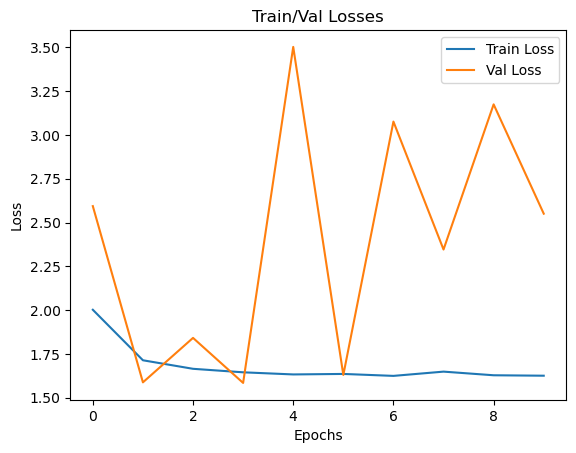

train_losses=[2.001936535589889, 1.7135609888261365, 1.6648316400300156, 1.6448155496893206, 1.6326860096505893, 1.635519093677928, 1.6244182521205528, 1.648702833372327, 1.627939789022352, 1.6254522120622996]
[2.593734152477943, 1.587478077850459, 1.8413249629041168, 1.5842283179789234, 3.502772900955809, 1.6296934361106779, 3.076402582273893, 2.3459563185832253, 3.1747331520531077, 2.5506407026132925]
Params lr=0.01, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 465.83it/s]

Epoch [1 out of 10], Train --> loss: 2.2220 & accuracy: 19.44%, Validation --> loss: 2.2172 & accuracy: 20.51%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.22it/s]

Epoch [2 out of 10], Train --> loss: 2.2068 & accuracy: 19.87%, Validation --> loss: 2.1714 & accuracy: 22.55%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.60it/s]

Epoch [3 out of 10], Train --> loss: 2.1185 & accuracy: 24.03%, Validation --> loss: 2.1866 & accuracy: 19.22%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 481.15it/s]

Epoch [4 out of 10], Train --> loss: 2.0651 & accuracy: 26.34%, Validation --> loss: 2.7187 & accuracy: 9.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 476.20it/s]

Epoch [5 out of 10], Train --> loss: 2.0495 & accuracy: 26.53%, Validation --> loss: 4.8497 & accuracy: 16.77%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 476.48it/s]

Epoch [6 out of 10], Train --> loss: 2.0593 & accuracy: 26.40%, Validation --> loss: 3.1586 & accuracy: 18.23%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 495.14it/s]

Epoch [7 out of 10], Train --> loss: 2.0670 & accuracy: 25.76%, Validation --> loss: 2.5068 & accuracy: 14.63%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 479.44it/s]

Epoch [8 out of 10], Train --> loss: 2.0685 & accuracy: 26.40%, Validation --> loss: 2.2613 & accuracy: 19.22%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 473.46it/s]

Epoch [9 out of 10], Train --> loss: 2.0617 & accuracy: 26.16%, Validation --> loss: 2.4292 & accuracy: 18.30%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 482.97it/s]

Epoch [10 out of 10], Train --> loss: 2.0574 & accuracy: 25.69%, Validation --> loss: 5.5113 & accuracy: 19.69%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 610.41it/s]


Test Accuracy: 19.22%


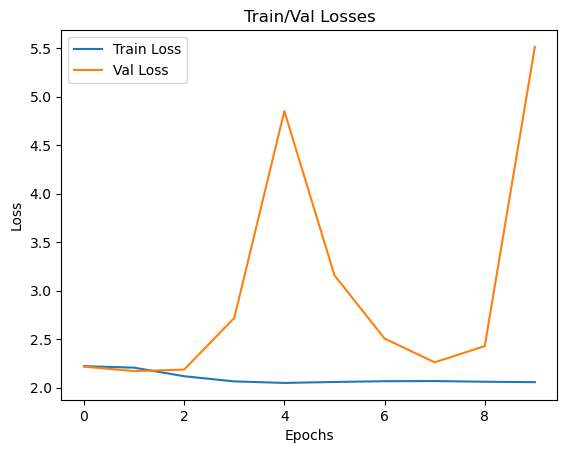

train_losses=[2.2219514348723006, 2.206809528687033, 2.118547714342536, 2.065116546578854, 2.049497482597187, 2.059262091754585, 2.0669702271345756, 2.0685355761267257, 2.061725538447156, 2.0574232074339087]
[2.21724494139841, 2.171431250367428, 2.186604069420165, 2.7186855637222713, 4.849705735598605, 3.1586102470298485, 2.5067546104360945, 2.2613017262856654, 2.4291554444406662, 5.511279332125845]
Params lr=0.01, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 326/326 [00:00<00:00, 484.60it/s]

Epoch [1 out of 10], Train --> loss: 2.2313 & accuracy: 18.91%, Validation --> loss: 2.2789 & accuracy: 16.54%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 463.89it/s]

Epoch [2 out of 10], Train --> loss: 2.2269 & accuracy: 19.32%, Validation --> loss: 2.2244 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 490.77it/s]

Epoch [3 out of 10], Train --> loss: 2.2256 & accuracy: 19.34%, Validation --> loss: 2.4359 & accuracy: 10.87%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 346.27it/s]

Epoch [4 out of 10], Train --> loss: 2.2261 & accuracy: 19.27%, Validation --> loss: 2.2233 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 459.87it/s]

Epoch [5 out of 10], Train --> loss: 2.2261 & accuracy: 19.40%, Validation --> loss: 2.2386 & accuracy: 20.09%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 469.52it/s]

Epoch [6 out of 10], Train --> loss: 2.2267 & accuracy: 19.41%, Validation --> loss: 2.2239 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 463.62it/s]

Epoch [7 out of 10], Train --> loss: 2.2253 & accuracy: 19.35%, Validation --> loss: 2.2258 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 413.43it/s]

Epoch [8 out of 10], Train --> loss: 2.2259 & accuracy: 19.34%, Validation --> loss: 2.2231 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 477.58it/s]

Epoch [9 out of 10], Train --> loss: 2.2251 & accuracy: 19.46%, Validation --> loss: 2.2274 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 460.94it/s]

Epoch [10 out of 10], Train --> loss: 2.2254 & accuracy: 19.49%, Validation --> loss: 2.2235 & accuracy: 19.99%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 638.02it/s]


Test Accuracy: 19.59%


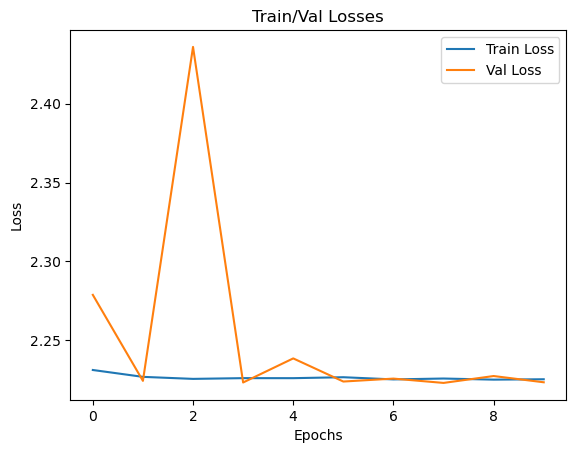

train_losses=[2.231256218275167, 2.2269093593877214, 2.225627197739532, 2.226096870712421, 2.226080694048452, 2.226678647203929, 2.2252905749688683, 2.2258534107340098, 2.2251485486367515, 2.22539127156848]
[2.2788607160006564, 2.224370662054401, 2.4359407165299163, 2.223348362314189, 2.2386031670073057, 2.2239471652025093, 2.225802641339097, 2.2230684120962225, 2.227433740727009, 2.2234741694356766]


In [21]:
res_bn = train_grid_search(params=params, bn=True, num_epochs=num_epochs, results=res_bn)

In [22]:
res_bn

,optimizer,accuracy,learning_rate,weight_decay
0,Adam,0.702324,0.0001,0.0001
0,Adam,0.715383,0.0001,0.0010
0,Adam,0.695602,0.0001,0.0100
0,Adam,0.739197,0.0010,0.0001
0,Adam,0.723449,0.0010,0.0010
0,Adam,0.716535,0.0010,0.0100
0,Adam,0.700211,0.0100,0.0001
0,Adam,0.705012,0.0100,0.0010
0,Adam,0.629921,0.0100,0.0100
0,RMSprop,0.641060,0.0001,0.0001


## Дообучение

Выберем 3 лучшие модели и попытаемся обучить модель с большим количеством эпох для получения лучших результатов.

In [35]:
best_top_3_res_bn = res_bn.sort_values(by=['accuracy'], ascending=False)[:3]

params_2 = []
for opt, _, lr, w in best_top_3_res_bn.values:
    params_2 += [(get_optim(opt), lr, w)]

In [17]:
params_2

Params lr=0.001, w=0.0001, opt=<class 'my_adam.Adam'>


100%|██████████| 326/326 [00:00<00:00, 460.30it/s]

Epoch [1 out of 35], Train --> loss: 1.8535 & accuracy: 37.93%, Validation --> loss: 1.7430 & accuracy: 41.43%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 507.26it/s]

Epoch [2 out of 35], Train --> loss: 1.5247 & accuracy: 50.36%, Validation --> loss: 1.4550 & accuracy: 53.79%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 441.00it/s]

Epoch [3 out of 35], Train --> loss: 1.3638 & accuracy: 56.26%, Validation --> loss: 1.4582 & accuracy: 55.33%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 471.19it/s]

Epoch [4 out of 35], Train --> loss: 1.2896 & accuracy: 58.59%, Validation --> loss: 1.3751 & accuracy: 54.41%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 481.83it/s]

Epoch [5 out of 35], Train --> loss: 1.2262 & accuracy: 60.95%, Validation --> loss: 1.0449 & accuracy: 68.75%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 474.00it/s]

Epoch [6 out of 35], Train --> loss: 1.1526 & accuracy: 63.13%, Validation --> loss: 1.0482 & accuracy: 67.68%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 497.13it/s]

Epoch [7 out of 35], Train --> loss: 1.1086 & accuracy: 64.81%, Validation --> loss: 0.9458 & accuracy: 72.36%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 481.51it/s]

Epoch [8 out of 35], Train --> loss: 1.0736 & accuracy: 65.79%, Validation --> loss: 0.9894 & accuracy: 70.60%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 495.03it/s]

Epoch [9 out of 35], Train --> loss: 1.0472 & accuracy: 67.28%, Validation --> loss: 0.9777 & accuracy: 71.71%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 509.51it/s]

Epoch [10 out of 35], Train --> loss: 1.0167 & accuracy: 67.59%, Validation --> loss: 0.9631 & accuracy: 70.64%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 491.44it/s]

Epoch [11 out of 35], Train --> loss: 0.9953 & accuracy: 68.06%, Validation --> loss: 0.9413 & accuracy: 72.00%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 497.52it/s]

Epoch [12 out of 35], Train --> loss: 0.9772 & accuracy: 68.76%, Validation --> loss: 0.8430 & accuracy: 74.88%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 493.83it/s]

Epoch [13 out of 35], Train --> loss: 0.9508 & accuracy: 70.07%, Validation --> loss: 0.9423 & accuracy: 71.71%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 505.65it/s]

Epoch [14 out of 35], Train --> loss: 0.9320 & accuracy: 70.46%, Validation --> loss: 0.8851 & accuracy: 73.50%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 490.97it/s]

Epoch [15 out of 35], Train --> loss: 0.9201 & accuracy: 71.05%, Validation --> loss: 0.8334 & accuracy: 76.49%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 508.80it/s]

Epoch [16 out of 35], Train --> loss: 0.9040 & accuracy: 71.18%, Validation --> loss: 0.8379 & accuracy: 75.40%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 471.07it/s]

Epoch [17 out of 35], Train --> loss: 0.8898 & accuracy: 71.74%, Validation --> loss: 0.9009 & accuracy: 73.32%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 476.38it/s]

Epoch [18 out of 35], Train --> loss: 0.8858 & accuracy: 71.64%, Validation --> loss: 0.8655 & accuracy: 73.34%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 476.20it/s]

Epoch [19 out of 35], Train --> loss: 0.8689 & accuracy: 72.40%, Validation --> loss: 0.8680 & accuracy: 74.71%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 513.42it/s]

Epoch [20 out of 35], Train --> loss: 0.8557 & accuracy: 73.03%, Validation --> loss: 0.8083 & accuracy: 76.74%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 508.46it/s]

Epoch [21 out of 35], Train --> loss: 0.8449 & accuracy: 73.43%, Validation --> loss: 0.7286 & accuracy: 79.41%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 465.56it/s]

Epoch [22 out of 35], Train --> loss: 0.8376 & accuracy: 73.80%, Validation --> loss: 0.9373 & accuracy: 72.10%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 488.92it/s]

Epoch [23 out of 35], Train --> loss: 0.8356 & accuracy: 73.48%, Validation --> loss: 0.8183 & accuracy: 76.88%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 475.19it/s]

Epoch [24 out of 35], Train --> loss: 0.8148 & accuracy: 73.95%, Validation --> loss: 0.7411 & accuracy: 78.74%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 480.34it/s]

Epoch [25 out of 35], Train --> loss: 0.8125 & accuracy: 74.12%, Validation --> loss: 0.7223 & accuracy: 80.20%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 494.25it/s]

Epoch [26 out of 35], Train --> loss: 0.8085 & accuracy: 74.37%, Validation --> loss: 0.8362 & accuracy: 76.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 494.45it/s]

Epoch [27 out of 35], Train --> loss: 0.7843 & accuracy: 75.15%, Validation --> loss: 0.7360 & accuracy: 78.87%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 492.42it/s]

Epoch [28 out of 35], Train --> loss: 0.7858 & accuracy: 75.13%, Validation --> loss: 0.7687 & accuracy: 77.45%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 498.67it/s]

Epoch [29 out of 35], Train --> loss: 0.7784 & accuracy: 75.35%, Validation --> loss: 0.8001 & accuracy: 76.17%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 518.98it/s]

Epoch [30 out of 35], Train --> loss: 0.7707 & accuracy: 75.30%, Validation --> loss: 0.7559 & accuracy: 77.57%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 500.61it/s]

Epoch [31 out of 35], Train --> loss: 0.7665 & accuracy: 75.66%, Validation --> loss: 0.7278 & accuracy: 78.43%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 505.77it/s]

Epoch [32 out of 35], Train --> loss: 0.7579 & accuracy: 76.16%, Validation --> loss: 0.8012 & accuracy: 76.51%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 520.68it/s]

Epoch [33 out of 35], Train --> loss: 0.7551 & accuracy: 75.92%, Validation --> loss: 0.7583 & accuracy: 78.38%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 505.11it/s]

Epoch [34 out of 35], Train --> loss: 0.7456 & accuracy: 75.88%, Validation --> loss: 0.8463 & accuracy: 75.05%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 512.94it/s]

Epoch [35 out of 35], Train --> loss: 0.7333 & accuracy: 76.67%, Validation --> loss: 0.8151 & accuracy: 76.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 725.94it/s]


Test Accuracy: 80.45%


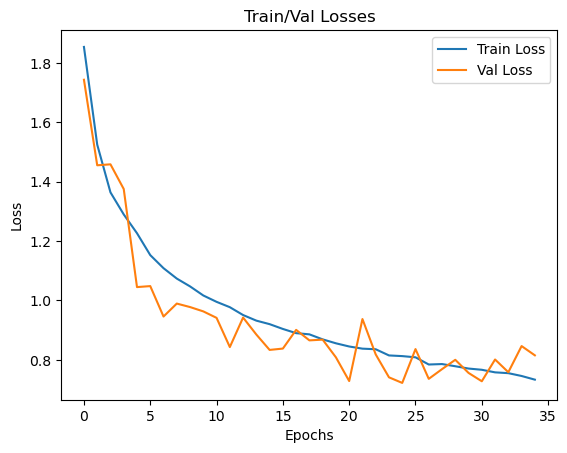

train_losses=[1.8535115189632878, 1.5246627492380949, 1.3638008727181343, 1.289596302946958, 1.2262450951493464, 1.1525884479421624, 1.1085746651329387, 1.073609802419872, 1.0472231899172113, 1.0166706172735094, 0.9952512593816869, 0.97723729670414, 0.9508109350220948, 0.9319708410038193, 0.9201361234836315, 0.9039562284465759, 0.889848611047191, 0.885780890668226, 0.8688768839575178, 0.8556555722898785, 0.8449205676073669, 0.8376259716791308, 0.8356280791045334, 0.8148225837039508, 0.8125354353962223, 0.8085193862700792, 0.784260432165797, 0.7857831245926302, 0.7784129274285151, 0.7706601367247635, 0.7665097427235404, 0.7578564693324393, 0.7551064631356622, 0.7456175121500196, 0.7332788634181205]
[1.7429621380530984, 1.4549983394292234, 1.4582207440598611, 1.3751182561637434, 1.0448921877730843, 1.0482489009576341, 0.9457902179722406, 0.9894094830093209, 0.9776816286740859, 0.963086578469335, 0.941327154087874, 0.8429818253941331, 0.9423214294976252, 0.8850916259310728, 0.833392692855

100%|██████████| 326/326 [00:00<00:00, 492.39it/s]

Epoch [1 out of 35], Train --> loss: 1.8145 & accuracy: 40.91%, Validation --> loss: 2.0870 & accuracy: 37.49%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 452.86it/s]

Epoch [2 out of 35], Train --> loss: 1.5425 & accuracy: 52.21%, Validation --> loss: 1.5258 & accuracy: 53.54%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 478.39it/s]

Epoch [3 out of 35], Train --> loss: 1.4351 & accuracy: 55.97%, Validation --> loss: 1.8119 & accuracy: 41.35%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 516.89it/s]

Epoch [4 out of 35], Train --> loss: 1.3571 & accuracy: 59.02%, Validation --> loss: 1.5289 & accuracy: 50.53%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 520.66it/s]

Epoch [5 out of 35], Train --> loss: 1.3005 & accuracy: 60.58%, Validation --> loss: 1.9577 & accuracy: 37.87%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 510.93it/s]

Epoch [6 out of 35], Train --> loss: 1.2490 & accuracy: 62.49%, Validation --> loss: 1.2329 & accuracy: 61.97%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 521.33it/s]

Epoch [7 out of 35], Train --> loss: 1.2214 & accuracy: 62.88%, Validation --> loss: 1.6944 & accuracy: 47.74%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 519.76it/s]

Epoch [8 out of 35], Train --> loss: 1.1764 & accuracy: 64.61%, Validation --> loss: 1.2132 & accuracy: 62.32%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 494.56it/s]

Epoch [9 out of 35], Train --> loss: 1.1461 & accuracy: 65.53%, Validation --> loss: 1.2552 & accuracy: 62.47%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 508.09it/s]

Epoch [10 out of 35], Train --> loss: 1.1266 & accuracy: 66.13%, Validation --> loss: 1.1912 & accuracy: 67.04%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 508.87it/s]

Epoch [11 out of 35], Train --> loss: 1.0984 & accuracy: 66.57%, Validation --> loss: 1.0557 & accuracy: 69.04%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 497.15it/s]

Epoch [12 out of 35], Train --> loss: 1.0769 & accuracy: 67.24%, Validation --> loss: 1.3124 & accuracy: 57.23%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 520.92it/s]

Epoch [13 out of 35], Train --> loss: 1.0560 & accuracy: 67.88%, Validation --> loss: 1.2577 & accuracy: 59.46%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 500.72it/s]

Epoch [14 out of 35], Train --> loss: 1.0362 & accuracy: 68.13%, Validation --> loss: 1.0104 & accuracy: 72.08%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 514.69it/s]

Epoch [15 out of 35], Train --> loss: 1.0267 & accuracy: 68.46%, Validation --> loss: 1.0063 & accuracy: 70.39%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 470.88it/s]

Epoch [16 out of 35], Train --> loss: 1.0168 & accuracy: 69.13%, Validation --> loss: 1.0190 & accuracy: 69.00%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 515.39it/s]

Epoch [17 out of 35], Train --> loss: 1.0029 & accuracy: 69.28%, Validation --> loss: 1.8131 & accuracy: 44.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 514.34it/s]

Epoch [18 out of 35], Train --> loss: 0.9874 & accuracy: 69.74%, Validation --> loss: 1.2664 & accuracy: 60.02%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 517.74it/s]

Epoch [19 out of 35], Train --> loss: 0.9735 & accuracy: 69.93%, Validation --> loss: 1.1506 & accuracy: 66.08%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 377.08it/s]

Epoch [20 out of 35], Train --> loss: 0.9599 & accuracy: 70.66%, Validation --> loss: 1.3956 & accuracy: 57.37%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 543.87it/s]

Epoch [21 out of 35], Train --> loss: 0.9490 & accuracy: 70.51%, Validation --> loss: 1.0836 & accuracy: 67.66%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 513.03it/s]

Epoch [22 out of 35], Train --> loss: 0.9412 & accuracy: 70.77%, Validation --> loss: 0.8726 & accuracy: 76.11%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 530.43it/s]

Epoch [23 out of 35], Train --> loss: 0.9351 & accuracy: 71.13%, Validation --> loss: 0.9836 & accuracy: 69.12%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 436.73it/s]

Epoch [24 out of 35], Train --> loss: 0.9215 & accuracy: 71.14%, Validation --> loss: 1.2364 & accuracy: 59.82%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:01<00:00, 202.76it/s]

Epoch [25 out of 35], Train --> loss: 0.9137 & accuracy: 71.69%, Validation --> loss: 1.0976 & accuracy: 67.49%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:01<00:00, 203.98it/s]


Epoch [26 out of 35], Train --> loss: 0.9095 & accuracy: 71.72%, Validation --> loss: 0.9895 & accuracy: 71.31%
Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:01<00:00, 310.60it/s]

Epoch [27 out of 35], Train --> loss: 0.8976 & accuracy: 72.27%, Validation --> loss: 1.0368 & accuracy: 68.66%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:01<00:00, 178.10it/s]

Epoch [28 out of 35], Train --> loss: 0.8911 & accuracy: 72.40%, Validation --> loss: 1.2681 & accuracy: 63.32%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 531.93it/s]

Epoch [29 out of 35], Train --> loss: 0.8892 & accuracy: 72.49%, Validation --> loss: 1.4185 & accuracy: 55.37%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:01<00:00, 312.72it/s]

Epoch [30 out of 35], Train --> loss: 0.8816 & accuracy: 72.66%, Validation --> loss: 2.5681 & accuracy: 41.04%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:01<00:00, 311.00it/s]

Epoch [31 out of 35], Train --> loss: 0.8756 & accuracy: 72.71%, Validation --> loss: 0.9647 & accuracy: 71.92%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 584.98it/s]

Epoch [32 out of 35], Train --> loss: 0.8781 & accuracy: 72.60%, Validation --> loss: 0.8103 & accuracy: 77.82%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:01<00:00, 222.08it/s]

Epoch [33 out of 35], Train --> loss: 0.8564 & accuracy: 73.59%, Validation --> loss: 0.8671 & accuracy: 74.38%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 398.90it/s]

Epoch [34 out of 35], Train --> loss: 0.8605 & accuracy: 73.03%, Validation --> loss: 0.8095 & accuracy: 78.78%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 573.96it/s]

Epoch [35 out of 35], Train --> loss: 0.8553 & accuracy: 73.05%, Validation --> loss: 0.9116 & accuracy: 73.96%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 702.64it/s]


Test Accuracy: 77.75%


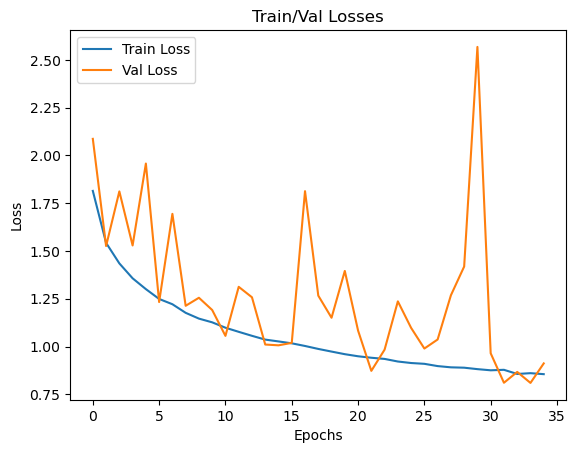

train_losses=[1.8145047013294495, 1.542488958474861, 1.435123010760262, 1.3570629489678208, 1.3004763482536221, 1.2490189802903, 1.2213779158215003, 1.176395392866545, 1.1460868426456978, 1.1266030875219177, 1.0984487080354295, 1.076914529097245, 1.0560228487679852, 1.0362362150909714, 1.0266709644948282, 1.0167550268810466, 1.0028848556741592, 0.9874119625159307, 0.9735396575360071, 0.9599232069129402, 0.948993706964128, 0.9412260605580246, 0.9351359005851496, 0.9215277028935296, 0.9136780462644067, 0.9094708444244485, 0.8975994703681788, 0.8911238219789279, 0.8891960984459304, 0.8816432195691286, 0.875559139247131, 0.8781233556717405, 0.8563865355906948, 0.8605246411124315, 0.855343266314442]
[2.0869615578943965, 1.5257820933143054, 1.8119246080243514, 1.5289056785633228, 1.9577047627396378, 1.2328542721417783, 1.694366279738081, 1.2131953612427038, 1.2551978288984007, 1.1912071926096466, 1.0557432982819213, 1.3124303238157846, 1.2577000709216288, 1.0104260644846899, 1.00629326381200

100%|██████████| 326/326 [00:00<00:00, 521.00it/s]

Epoch [1 out of 35], Train --> loss: 1.8699 & accuracy: 36.89%, Validation --> loss: 1.5750 & accuracy: 48.09%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 485.86it/s]

Epoch [2 out of 35], Train --> loss: 1.5001 & accuracy: 51.35%, Validation --> loss: 1.3651 & accuracy: 58.23%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 605.53it/s]

Epoch [3 out of 35], Train --> loss: 1.3716 & accuracy: 56.20%, Validation --> loss: 1.2190 & accuracy: 63.43%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 580.49it/s]

Epoch [4 out of 35], Train --> loss: 1.3004 & accuracy: 58.25%, Validation --> loss: 1.1511 & accuracy: 64.84%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 590.38it/s]


Epoch [5 out of 35], Train --> loss: 1.2191 & accuracy: 61.25%, Validation --> loss: 1.1591 & accuracy: 63.09%
Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 567.71it/s]

Epoch [6 out of 35], Train --> loss: 1.1611 & accuracy: 62.97%, Validation --> loss: 1.0197 & accuracy: 68.91%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 576.98it/s]

Epoch [7 out of 35], Train --> loss: 1.1181 & accuracy: 64.32%, Validation --> loss: 0.9467 & accuracy: 72.46%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 574.97it/s]

Epoch [8 out of 35], Train --> loss: 1.0737 & accuracy: 65.76%, Validation --> loss: 1.0242 & accuracy: 67.74%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 596.61it/s]

Epoch [9 out of 35], Train --> loss: 1.0566 & accuracy: 66.24%, Validation --> loss: 0.9080 & accuracy: 73.44%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:01<00:00, 315.07it/s]

Epoch [10 out of 35], Train --> loss: 1.0122 & accuracy: 67.84%, Validation --> loss: 1.0539 & accuracy: 68.06%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 583.26it/s]

Epoch [11 out of 35], Train --> loss: 0.9935 & accuracy: 68.22%, Validation --> loss: 0.8791 & accuracy: 74.15%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 585.23it/s]

Epoch [12 out of 35], Train --> loss: 0.9652 & accuracy: 69.42%, Validation --> loss: 1.0107 & accuracy: 69.21%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 572.45it/s]

Epoch [13 out of 35], Train --> loss: 0.9628 & accuracy: 69.31%, Validation --> loss: 0.8647 & accuracy: 74.52%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 581.05it/s]

Epoch [14 out of 35], Train --> loss: 0.9358 & accuracy: 70.15%, Validation --> loss: 0.9560 & accuracy: 72.54%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 569.84it/s]

Epoch [15 out of 35], Train --> loss: 0.9246 & accuracy: 70.50%, Validation --> loss: 0.8123 & accuracy: 77.03%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 431.30it/s]

Epoch [16 out of 35], Train --> loss: 0.9011 & accuracy: 71.72%, Validation --> loss: 0.8473 & accuracy: 75.96%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 447.48it/s]

Epoch [17 out of 35], Train --> loss: 0.8952 & accuracy: 71.31%, Validation --> loss: 0.8239 & accuracy: 75.59%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 585.49it/s]

Epoch [18 out of 35], Train --> loss: 0.8744 & accuracy: 72.05%, Validation --> loss: 1.1026 & accuracy: 66.14%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 602.79it/s]

Epoch [19 out of 35], Train --> loss: 0.8721 & accuracy: 72.24%, Validation --> loss: 1.0439 & accuracy: 68.31%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 592.22it/s]

Epoch [20 out of 35], Train --> loss: 0.8534 & accuracy: 73.16%, Validation --> loss: 0.7535 & accuracy: 79.14%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 597.61it/s]

Epoch [21 out of 35], Train --> loss: 0.8348 & accuracy: 73.44%, Validation --> loss: 0.8151 & accuracy: 76.34%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 595.74it/s]

Epoch [22 out of 35], Train --> loss: 0.8415 & accuracy: 73.29%, Validation --> loss: 0.8564 & accuracy: 76.90%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 594.57it/s]

Epoch [23 out of 35], Train --> loss: 0.8185 & accuracy: 74.02%, Validation --> loss: 0.7853 & accuracy: 77.49%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 555.96it/s]

Epoch [24 out of 35], Train --> loss: 0.8160 & accuracy: 73.97%, Validation --> loss: 0.7724 & accuracy: 77.80%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 578.61it/s]

Epoch [25 out of 35], Train --> loss: 0.8123 & accuracy: 74.22%, Validation --> loss: 0.8105 & accuracy: 76.78%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 472.10it/s]

Epoch [26 out of 35], Train --> loss: 0.7999 & accuracy: 74.58%, Validation --> loss: 0.8317 & accuracy: 75.51%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 586.68it/s]

Epoch [27 out of 35], Train --> loss: 0.7904 & accuracy: 74.96%, Validation --> loss: 0.7684 & accuracy: 78.07%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 575.40it/s]

Epoch [28 out of 35], Train --> loss: 0.7785 & accuracy: 75.33%, Validation --> loss: 0.7650 & accuracy: 78.47%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 615.70it/s]

Epoch [29 out of 35], Train --> loss: 0.7814 & accuracy: 75.23%, Validation --> loss: 0.9493 & accuracy: 70.29%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 494.18it/s]

Epoch [30 out of 35], Train --> loss: 0.7690 & accuracy: 75.47%, Validation --> loss: 0.7562 & accuracy: 77.95%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 395.55it/s]

Epoch [31 out of 35], Train --> loss: 0.7601 & accuracy: 75.80%, Validation --> loss: 0.7113 & accuracy: 80.31%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 603.85it/s]

Epoch [32 out of 35], Train --> loss: 0.7544 & accuracy: 76.22%, Validation --> loss: 0.7189 & accuracy: 80.05%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 597.73it/s]

Epoch [33 out of 35], Train --> loss: 0.7477 & accuracy: 75.98%, Validation --> loss: 0.8068 & accuracy: 75.67%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 590.00it/s]

Epoch [34 out of 35], Train --> loss: 0.7307 & accuracy: 76.47%, Validation --> loss: 0.7158 & accuracy: 80.24%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 326/326 [00:00<00:00, 432.02it/s]

Epoch [35 out of 35], Train --> loss: 0.7438 & accuracy: 76.22%, Validation --> loss: 0.7321 & accuracy: 79.01%


Checking gradient for parameter: classification.fc1.weight
Checking gradient for parameter: classification.fc1.bias
Checking gradient for parameter: classification.bn1.weight
Checking gradient for parameter: classification.bn1.bias
Checking gradient for parameter: classification.fc2.weight
Checking gradient for parameter: classification.fc2.bias
Checking gradient for parameter: classification.bn2.weight
Checking gradient for parameter: classification.bn2.bias
Gradients check passed!


100%|██████████| 1627/1627 [00:02<00:00, 788.30it/s]


Test Accuracy: 84.37%


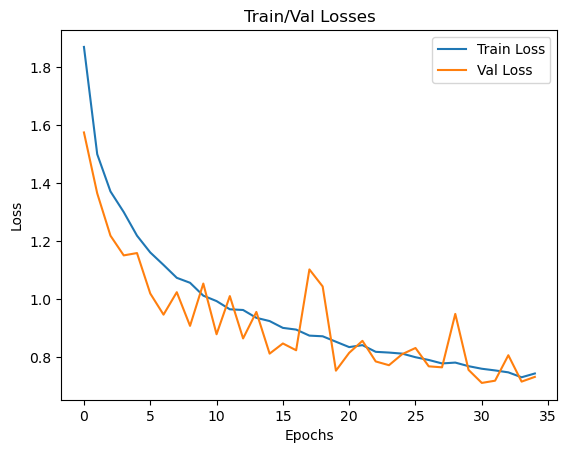

train_losses=[1.8699186697442045, 1.5000794420502337, 1.3715656416665207, 1.3003706013277379, 1.219104939708329, 1.1611477499641765, 1.1181469429885187, 1.0737013931281738, 1.0565865363256173, 1.012164643992843, 0.9934722858548347, 0.9651839500336054, 0.9627689536769636, 0.9357512711151038, 0.9245682352103762, 0.9010803778462696, 0.8951936789921352, 0.8743815196595067, 0.8720986461309793, 0.8533624598667735, 0.8347923357594764, 0.8415242526708843, 0.8184801979525481, 0.8159670812376816, 0.8122725911701696, 0.7999055346791646, 0.7903893190205739, 0.7784678109802775, 0.7813931323370443, 0.7690188899041138, 0.7601458279561887, 0.7543734615803132, 0.747716277139619, 0.7307442434807344, 0.7438094146011794]
[1.5750130226641346, 1.3651206699982743, 1.218989142610983, 1.1510544541788978, 1.1591005851886025, 1.0196544192502834, 0.9467054077087005, 1.0241560827186502, 0.9080133597177962, 1.053928711434449, 0.8790806874724254, 1.0106851465862954, 0.8646693219619295, 0.9560356771836251, 0.81226604

In [20]:
best_results_with_bn = pd.DataFrame(columns=['optimizer', 'accuracy', 'learning_rate', 'weight_decay'])
num_epochs = 35

best_results_with_bn = train_grid_search(params=params_2, bn=True, num_epochs=num_epochs, results=best_results_with_bn)

In [21]:
best_results_with_bn

,optimizer,accuracy,learning_rate,weight_decay
0,Adam,0.801997,0.0010,0.0001
0,RMSprop,0.787786,0.0001,0.0010
0,Adam,0.803150,0.0010,0.0010


Таким образом, лучший рузьтат точности равен 84% на тестовой выборке. Достигается при помощи собственной реализации оптимизатора Adam с параметрами lr = 0.001 и weight_decay = 0.001.

# Вывод

Из результатов проделанной работы следует, что обученная простая нейронная сеть достаточно хорошо распознает цифры (10 классов) из предоставленного датасета и достигает точности 84% используя слои BatchNormalization. При этом из графиков видно, что эти слои дают сильный выигрыш уже на первых эпохах обучения. Так, за 1 эпоху модель достигает точности 50%.

Более того, если добавить пару слоев FullyConnected, либо увеличить размер hidden_size до 1024, можно довольно просто получить вполне удовлетворительную точность.